<a href="https://colab.research.google.com/github/pedrohortencio/kaggle-competitions/blob/main/TMDB/TMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Competition's Page](https://www.kaggle.com/c/tmdb-box-office-prediction/overview)

# Importing Packages, Libraries and Downloading Data

In [1066]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!kaggle competitions download -c tmdb-box-office-prediction

kaggle.json
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [1067]:
import numpy as np                  
import pandas as pd
import ast
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
sns.set_theme(style='white', palette='muted')

from scipy.interpolate import make_interp_spline, BSpline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error as MSLE
import lightgbm as lgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping

In [1068]:
sample = pd.read_csv("/content/sample_submission.csv")
df_train = pd.read_csv("/content/train.csv.zip", compression='zip')
df_test = pd.read_csv("/content/test.csv.zip", compression='zip')

# Inspecting Data

In [1069]:
print(df_train.shape)
df_train.head(2)

(3000, 23)


id  ...   revenue
0   1  ...  12314651
1   2  ...  95149435

[2 rows x 23 columns]

In [1070]:
print(df_test.shape)
df_test.head(2)

(4398, 22)


id  ...                                               crew
0  3001  ...  [{'credit_id': '52fe44e7c3a368484e03d683', 'de...
1  3002  ...  [{'credit_id': '55807805c3a3685b1300060b', 'de...

[2 rows x 22 columns]

In [1071]:
df_train.isna().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

In [1072]:
df_test.isna().sum()

id                          0
belongs_to_collection    3521
budget                      0
genres                     16
homepage                 2978
imdb_id                     0
original_language           0
original_title              0
overview                   14
popularity                  0
poster_path                 1
production_companies      258
production_countries      102
release_date                1
runtime                     4
spoken_languages           42
status                      2
tagline                   863
title                       3
Keywords                  393
cast                       13
crew                       22
dtype: int64

# Treating Columns with Dicts

In [1073]:
columns_with_dicts = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']
def dict_columns(df):
    for column in columns_with_dicts:

        df[column] = df[column].apply(lambda row: {}
                                      if pd.isna(row)   # empty dict if NaN, the value if not
                                      else ast.literal_eval(row))  # (evaluated to see if it is a Python valid data structure)
                                                                                               

    return df

df_train = dict_columns(df_train)
df_test = dict_columns(df_test)

In [1074]:
df_train.isna().sum()

id                          0
belongs_to_collection       0
budget                      0
genres                      0
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies        0
production_countries        0
release_date                0
runtime                     2
spoken_languages            0
status                      0
tagline                   597
title                       0
Keywords                    0
cast                        0
crew                        0
revenue                     0
dtype: int64

# "belongs_to_collection" Column

In [1075]:
def extract_collection_name(x):
    if x != {}:
        return x[0]['name']
    else:
        return 0

def is_collection(x):
    if x != {}:
        return 1
    else:
        return 0

df_train['collection_name'] = df_train['belongs_to_collection'].apply(extract_collection_name)
df_train['part_of_collection'] = df_train['belongs_to_collection'].apply(is_collection)

df_test['collection_name'] = df_test['belongs_to_collection'].apply(extract_collection_name)
df_test['part_of_collection'] = df_test['belongs_to_collection'].apply(is_collection)

# Genres Column

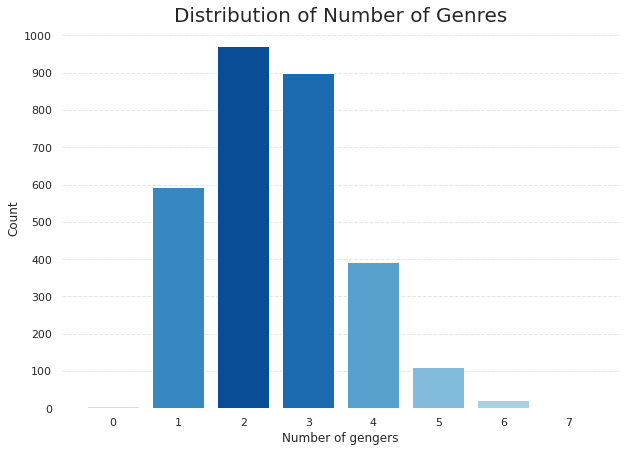

In [1076]:
number_of_genres = df_train['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()

fig = plt.figure(figsize=(10, 7))
plt.bar(x=number_of_genres.index, height=number_of_genres.values, color=sns.color_palette("Blues_r", n_colors=8))

plt.ylabel("Count")
plt.xlabel("Number of gengers")
plt.title("Distribution of Number of Genres", size=20)
plt.yticks([i for i in range(0, 1100, 100)])
plt.box(False)

plt.grid(axis='y', alpha=0.5, ls="--")

plt.show();

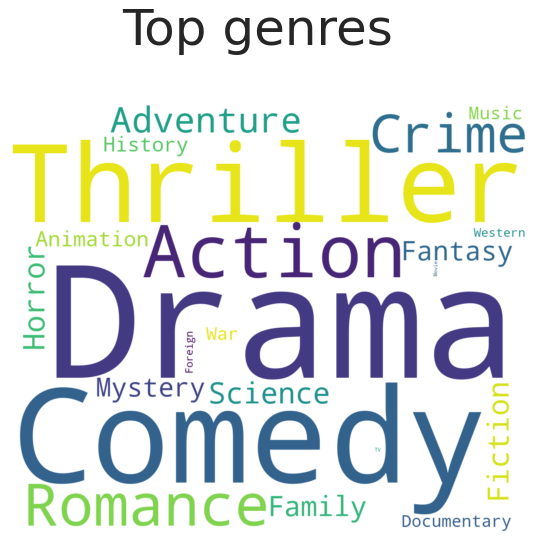

In [1077]:
list_of_genres = list(df_train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
text = ' '.join([i for j in list_of_genres for i in j])

plt.figure(figsize = (12, 8))

wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)

plt.imshow(wordcloud,interpolation="bilinear")

plt.suptitle('Top genres', size=50, y=1.05)
plt.axis("off")

plt.show();

In [1078]:
genres_occurances = Counter([i for j in list_of_genres for i in j]).most_common()
genres_occurances

[('Drama', 1531),
 ('Comedy', 1028),
 ('Thriller', 789),
 ('Action', 741),
 ('Romance', 571),
 ('Crime', 469),
 ('Adventure', 439),
 ('Horror', 301),
 ('Science Fiction', 290),
 ('Family', 260),
 ('Fantasy', 232),
 ('Mystery', 225),
 ('Animation', 141),
 ('History', 132),
 ('Music', 100),
 ('War', 100),
 ('Documentary', 87),
 ('Western', 43),
 ('Foreign', 31),
 ('TV Movie', 1)]

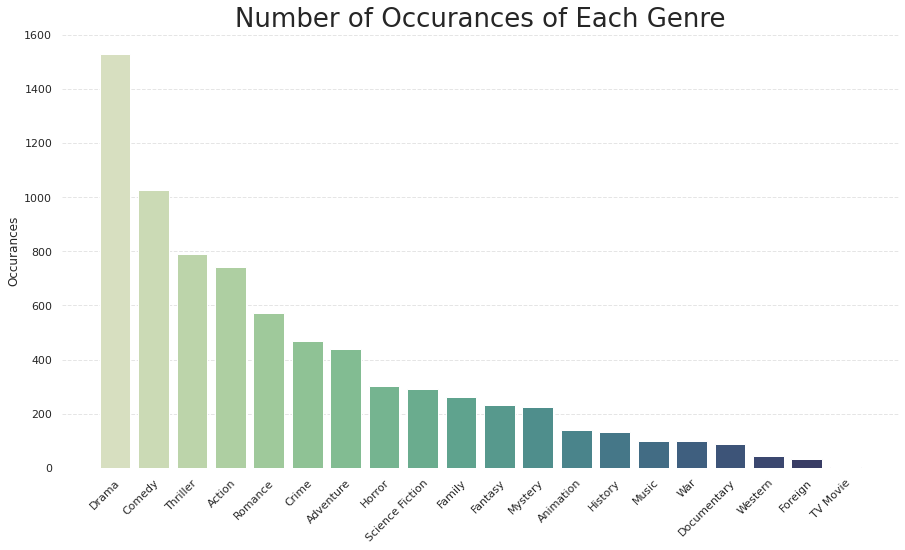

In [1079]:
genres_occurances = Counter([i for j in list_of_genres for i in j]).most_common()

genres_occurances_names = [x[0] for x in genres_occurances]
genres_occurances_values = [x[1] for x in genres_occurances]

fig = plt.figure(figsize=(15, 8))
plt.bar(x=genres_occurances_names, height=genres_occurances_values, color=sns.color_palette("ch:start=.5,rot=-.75", n_colors=22))

plt.xticks(rotation=45, rotation_mode="anchor", ha='right')
plt.box(False)
plt.grid(axis='y', alpha=0.5, ls='--')
plt.title("Number of Occurances of Each Genre", size=26)
plt.ylabel("Occurances")

plt.show();

In [1080]:
df_train['num_genres'] = df_train['genres'].apply(lambda x: len(x) if x != {} else 0)
df_test['num_genres'] = df_test['genres'].apply(lambda x: len(x) if x != {} else 0)

In [1081]:
df_train['all_genres'] = df_train['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
df_test['all_genres'] = df_test['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

# "production_companies" Column

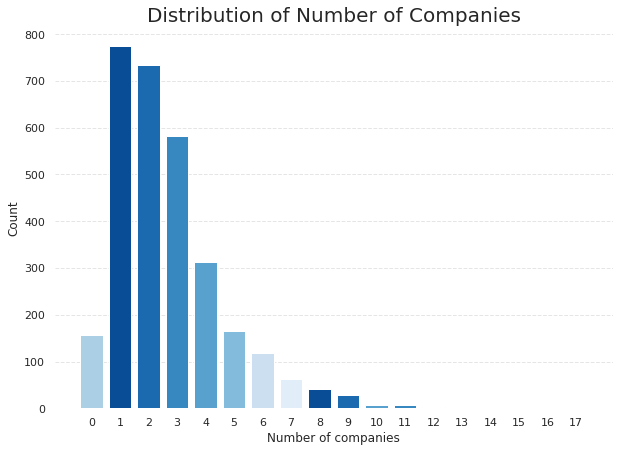

In [1082]:
number_of_companies = df_train['production_companies'].apply(lambda x: len(x) if x != {} else 0).value_counts()

fig = plt.figure(figsize=(10, 7))
plt.bar(x=number_of_companies.index, height=number_of_companies.values, color=sns.color_palette("Blues_r", n_colors=8))

plt.ylabel("Count")
plt.xlabel("Number of companies")
plt.title("Distribution of Number of Companies", size=20)
plt.box(False)
plt.xticks([i for i in range(0, 18)])

plt.grid(axis='y', alpha=0.5, ls="--")

plt.show();

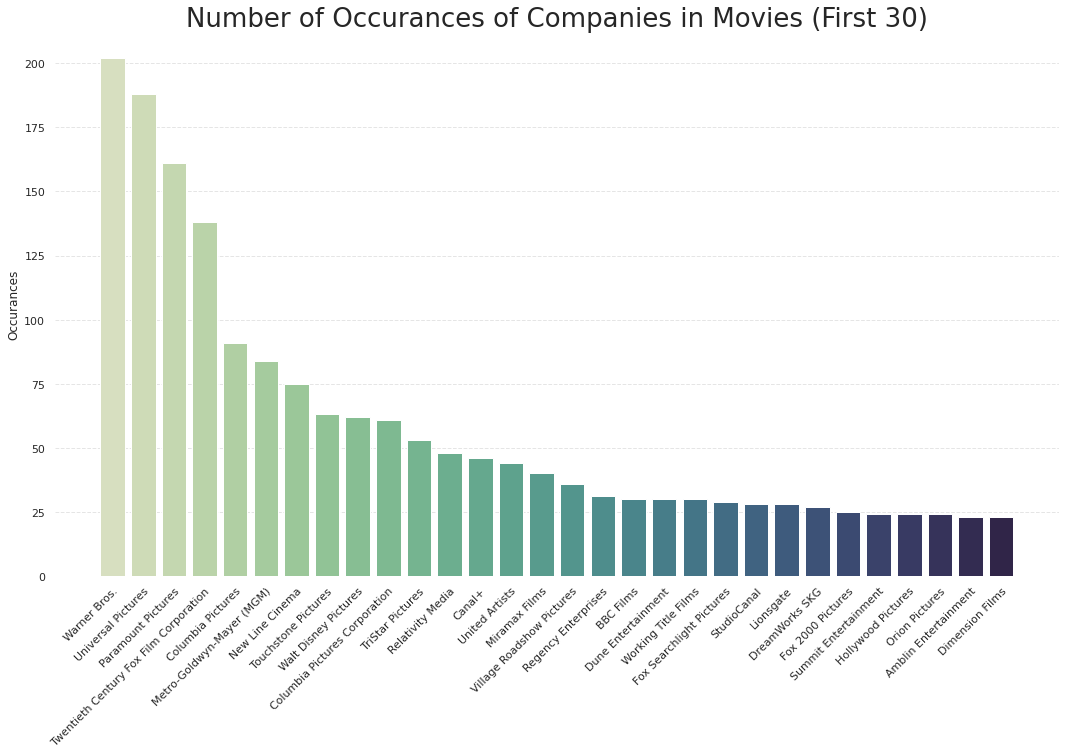

In [1083]:
list_of_companies = list(df_train['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
count_companies = Counter([i for j in list_of_companies for i in j]).most_common(30)

companies_names = []
occurance_values = []

for companie in count_companies:
    name, value = companie
    
    companies_names.append(name)
    occurance_values.append(value)

fig = plt.figure(figsize=(18, 10))
plt.bar(x=companies_names, height=occurance_values, color=sns.color_palette("ch:start=.5,rot=-.75", n_colors=31))

plt.xticks(rotation=45, rotation_mode="anchor", ha='right')
plt.box(False)
plt.grid(axis='y', alpha=0.5, ls='--')
plt.title("Number of Occurances of Companies in Movies (First 30)", size=26)
plt.ylabel("Occurances")

plt.show();

In [1084]:
df_train['num_companies'] = df_train['production_companies'].apply(lambda x: len(x) if x != {} else 0)
df_test['num_companies'] = df_test['production_companies'].apply(lambda x: len(x) if x != {} else 0)

# "production_countries" Column

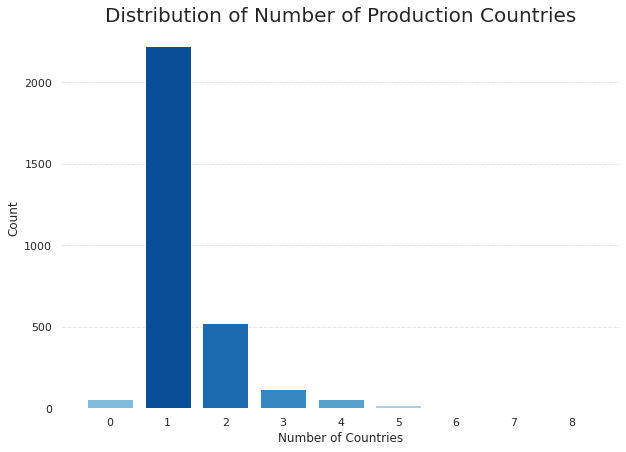

In [1085]:
production_countries_number = df_train['production_countries'].apply(lambda x: len(x) if x != {} else 0).value_counts()

fig = plt.figure(figsize=(10, 7))
plt.bar(x=production_countries_number.index, height=production_countries_number.values, color=sns.color_palette("Blues_r", n_colors=8))

plt.ylabel("Count")
plt.xlabel("Number of Countries")
plt.title("Distribution of Number of Production Countries", size=20)
plt.box(False)
plt.xticks([i for i in range(0, 9)])

plt.grid(axis='y', alpha=0.5, ls="--")

plt.show();

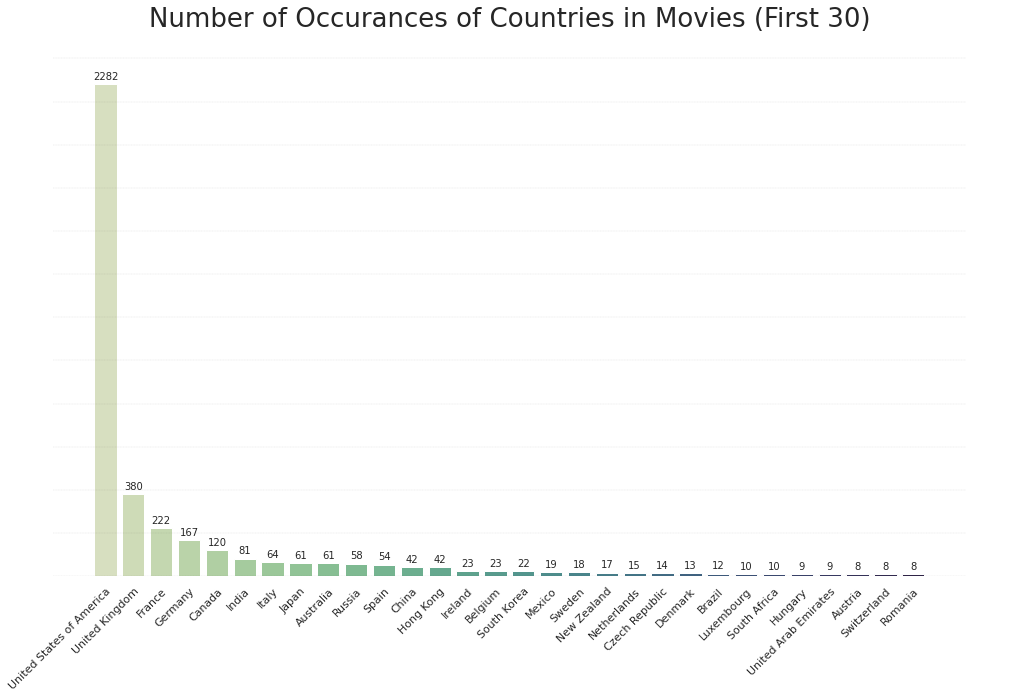

In [1086]:
list_of_countries = list(df_train['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
count_countries = Counter([i for j in list_of_countries for i in j]).most_common(30)

countries_names = [x[0] for x in count_countries]
occurance_values = [x[1] for x in count_countries]

fig = plt.figure(figsize=(18, 10))

ax = plt.gca()

rects1 = ax.bar(x=countries_names, height=occurance_values, color=sns.color_palette("ch:start=.5,rot=-.75", n_colors=31))

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    fontsize = 10,
                    ha='center', va='bottom')

autolabel(rects1)

plt.xticks(rotation=45, rotation_mode="anchor", ha='right')
plt.box(False)
plt.hlines([i for i in range(0, 2600, 200)], *ax.get_xlim(), color='k', linestyles='--', lw=0.3, alpha=0.2)
plt.yticks([])
plt.title("Number of Occurances of Countries in Movies (First 30)", size=26)


plt.show();

In [1087]:
df_train['num_countries'] = df_train['production_countries'].apply(lambda x: len(x) if x != {} else 0)
df_test['num_countries'] = df_test['production_countries'].apply(lambda x: len(x) if x != {} else 0)

# "spoken_languages" Column

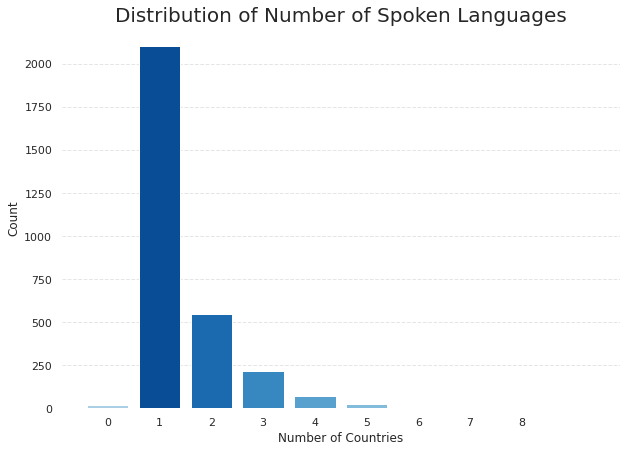

In [1088]:
spoken_languages_number = df_train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0).value_counts()

fig = plt.figure(figsize=(10, 7))
plt.bar(x=spoken_languages_number.index, height=spoken_languages_number.values, color=sns.color_palette("Blues_r", n_colors=8))

plt.ylabel("Count")
plt.xlabel("Number of Countries")
plt.title("Distribution of Number of Spoken Languages", size=20)
plt.box(False)
plt.xticks([i for i in range(0, 9)])

plt.grid(axis='y', alpha=0.5, ls="--")

plt.show();

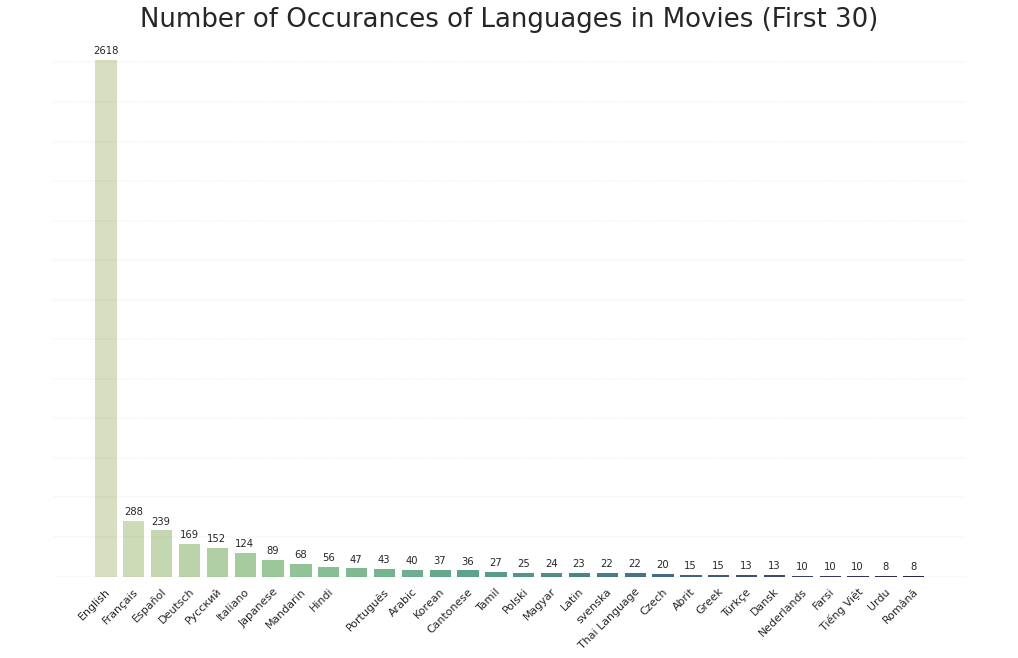

In [1089]:
list_of_languages  = list(df_train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
count_languages = Counter([i for j in list_of_languages for i in j]).most_common(30)

language_names = [x[0] for x in count_languages]
occurance_values = [x[1] for x in count_languages]

language_names = ['English','Français','Español','Deutsch','Pусский',
                  'Italiano','Japanese','Mandarin','Hindi','',
                  'Português','Arabic','Korean','Cantonese','Tamil',
                  'Polski','Magyar','Latin','svenska','Thai Language','Czech',
                  'Abrit','Greek','Türkçe','Dansk','Nederlands',
                  'Farsi','Tiếng Việt','Urdu','Română']

fig = plt.figure(figsize=(18, 10))


ax = plt.gca()

rects1 = ax.bar(x=language_names, height=occurance_values, color=sns.color_palette("ch:start=.5,rot=-.75", n_colors=31))

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    fontsize = 10,
                    ha='center', va='bottom')

autolabel(rects1)
plt.xticks(rotation=45, rotation_mode="anchor", ha='right')
plt.box(False)
plt.yticks([])
plt.hlines([i for i in range(0, 2800, 200)], *ax.get_xlim(), color='k', linestyles='--', lw=0.3, alpha=0.2)

plt.title("Number of Occurances of Languages in Movies (First 30)", size=26)

plt.show();

In [1090]:
df_train['num_languages'] = df_train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
df_test['num_languages'] = df_test['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)

# Keywords Column

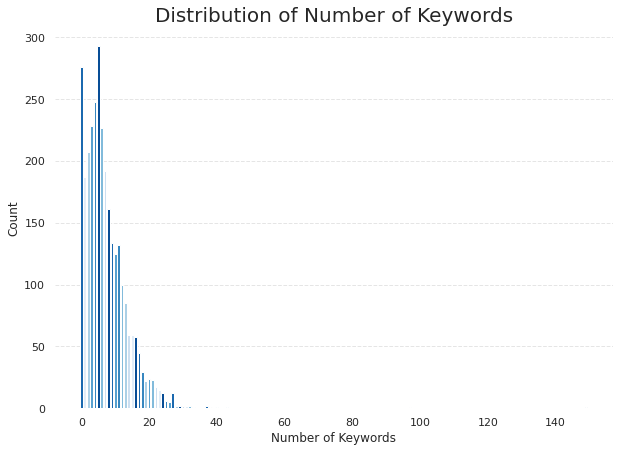

In [1091]:
keywords_number = df_train['Keywords'].apply(lambda x: len(x) if x != {} else 0).value_counts()

fig = plt.figure(figsize=(10, 7))
plt.bar(x=keywords_number.index, height=keywords_number.values, color=sns.color_palette("Blues_r", n_colors=8))

plt.ylabel("Count")
plt.xlabel("Number of Keywords")
plt.title("Distribution of Number of Keywords", size=20)
plt.box(False)

plt.grid(axis='y', alpha=0.5, ls="--")

plt.show();

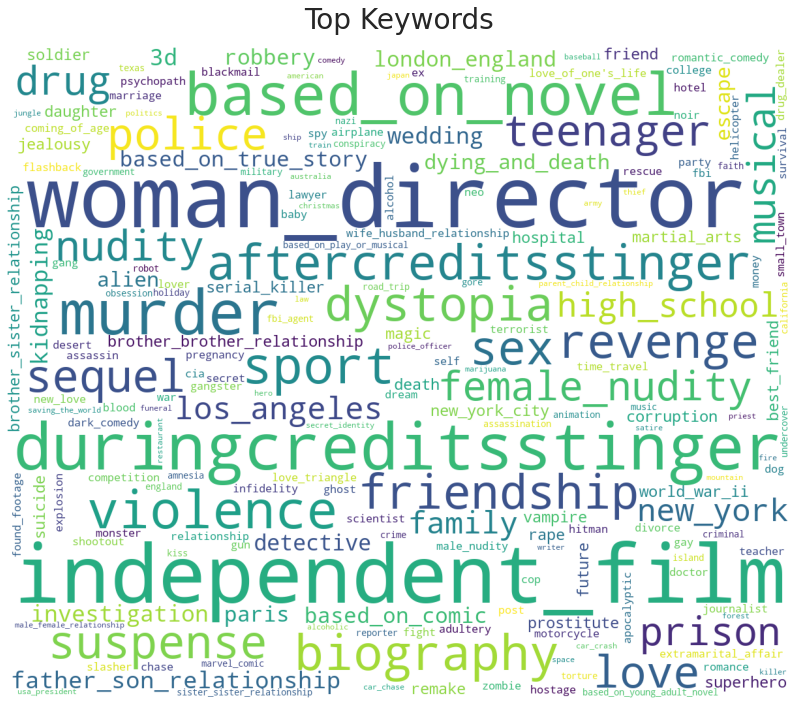

In [1092]:
list_of_keywords = list(df_train['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

plt.figure(figsize = (16, 12))
text = ' '.join(['_'.join(i.split(' ')) for j in list_of_keywords for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)

plt.imshow(wordcloud)
plt.title('Top Keywords', size = 28, y = 1.02)
plt.axis("off")
plt.show()

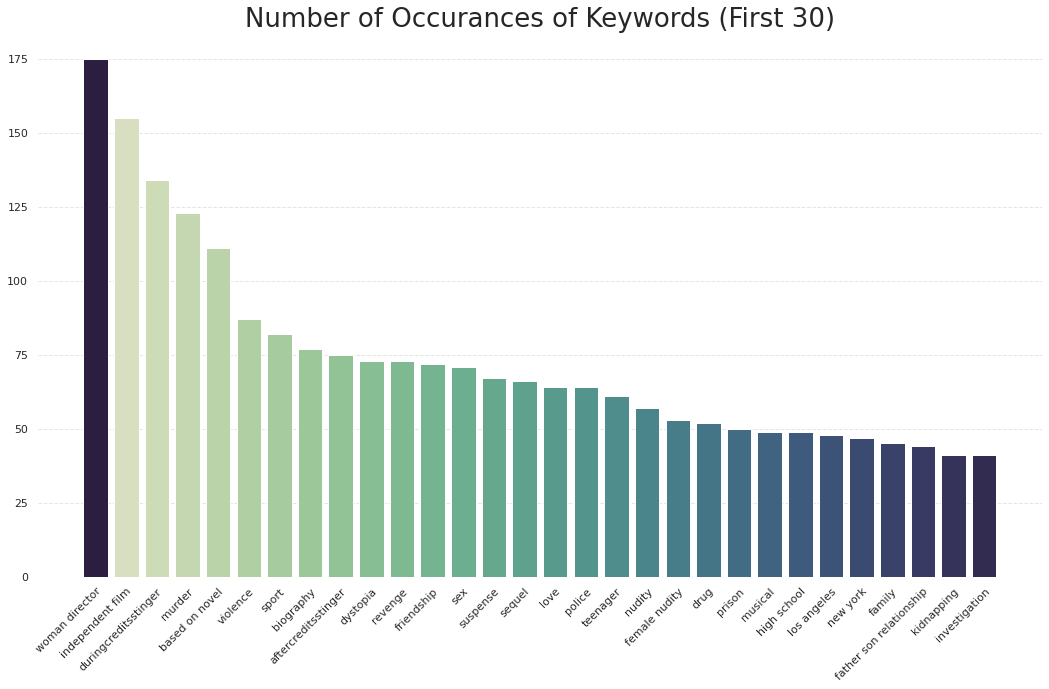

In [1093]:
list_of_keywords = list(df_train['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
count_keywords = Counter([i for j in list_of_keywords for i in j]).most_common(30)

keywords_names = [x[0] for x in count_keywords]
occurance_values = [x[1] for x in count_keywords]

for keyword in count_keywords:
    name, value = keyword
    
    keywords_names.append(name)
    occurance_values.append(value)

fig = plt.figure(figsize=(18, 10))

plt.bar(x=keywords_names, height=occurance_values, color=sns.color_palette("ch:start=.5,rot=-.75", n_colors=31))

plt.xticks(rotation=45, rotation_mode="anchor", ha='right')
plt.box(False)
plt.grid(axis='y', alpha=0.5, ls="--")

plt.title("Number of Occurances of Keywords (First 30)", size=26)


plt.show();

In [1094]:
df_train['num_Keywords'] = df_train['Keywords'].apply(lambda x: len(x) if x != {} else 0)
df_test['num_Keywords'] = df_test['Keywords'].apply(lambda x: len(x) if x != {} else 0)

# Cast Column

### Actors and Actress

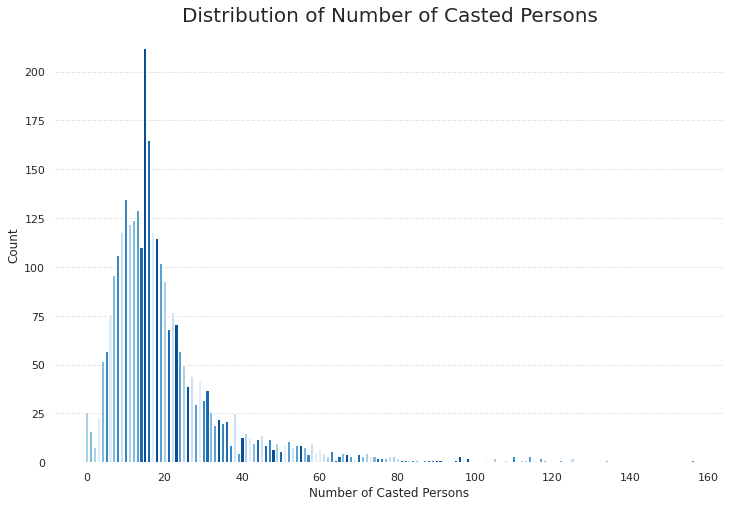

In [1095]:
casted_number = df_train['cast'].apply(lambda x: len(x) if x != {} else 0).value_counts()

fig = plt.figure(figsize=(12, 8))
plt.bar(x=casted_number.index, height=casted_number.values, color=sns.color_palette("Blues_r", n_colors=8))

plt.ylabel("Count")
plt.xlabel("Number of Casted Persons")
plt.title("Distribution of Number of Casted Persons", size=20)
plt.box(False)

plt.grid(axis='y', alpha=0.5, ls="--")

plt.show();

In [1096]:
df_train['cast'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(80)

15     212
16     165
10     135
13     129
12     124
      ... 
114      3
71       3
62       3
125      2
69       2
Name: cast, Length: 80, dtype: int64

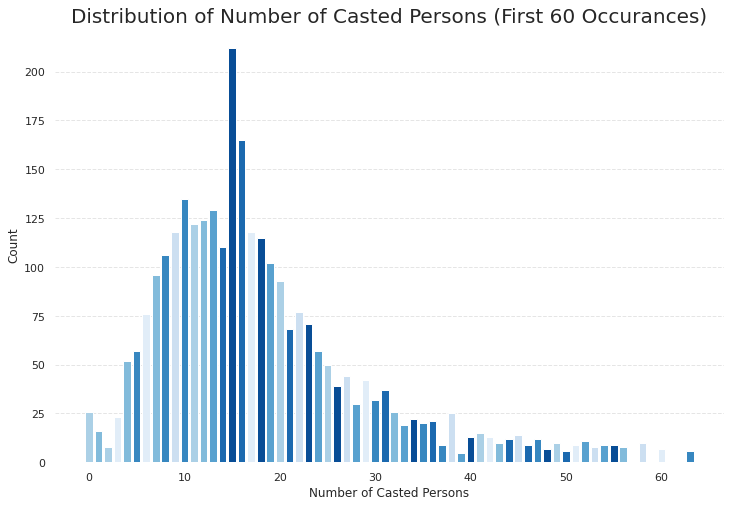

In [1097]:
casted_number = df_train['cast'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(60)

fig = plt.figure(figsize=(12, 8))
plt.bar(x=casted_number.index, height=casted_number.values, color=sns.color_palette("Blues_r", n_colors=8))

plt.ylabel("Count")
plt.xlabel("Number of Casted Persons")
plt.title("Distribution of Number of Casted Persons (First 60 Occurances)", size=20)
plt.box(False)

plt.grid(axis='y', alpha=0.5, ls="--")

plt.show();

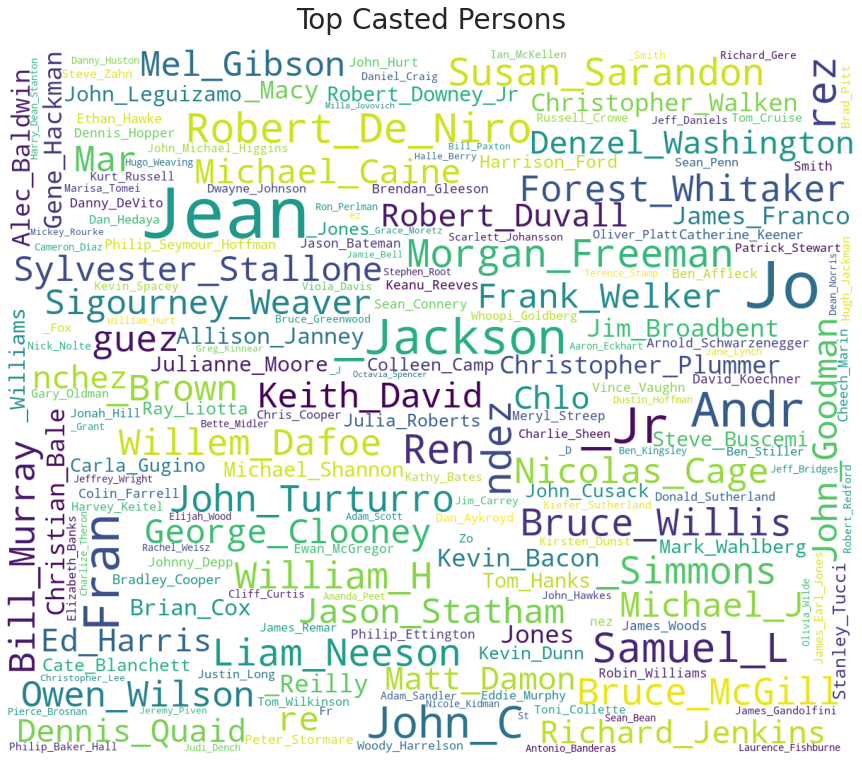

In [1098]:
list_of_cast_names = list(df_train['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

plt.figure(figsize = (18, 13))

text = ' '.join(['_'.join(i.split(' ')) for j in list_of_cast_names for i in j])
wordcloud = WordCloud(max_font_size=100, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)

plt.imshow(wordcloud)
plt.title('Top Casted Persons', size = 28, y = 1.02)
plt.axis("off")
plt.show()

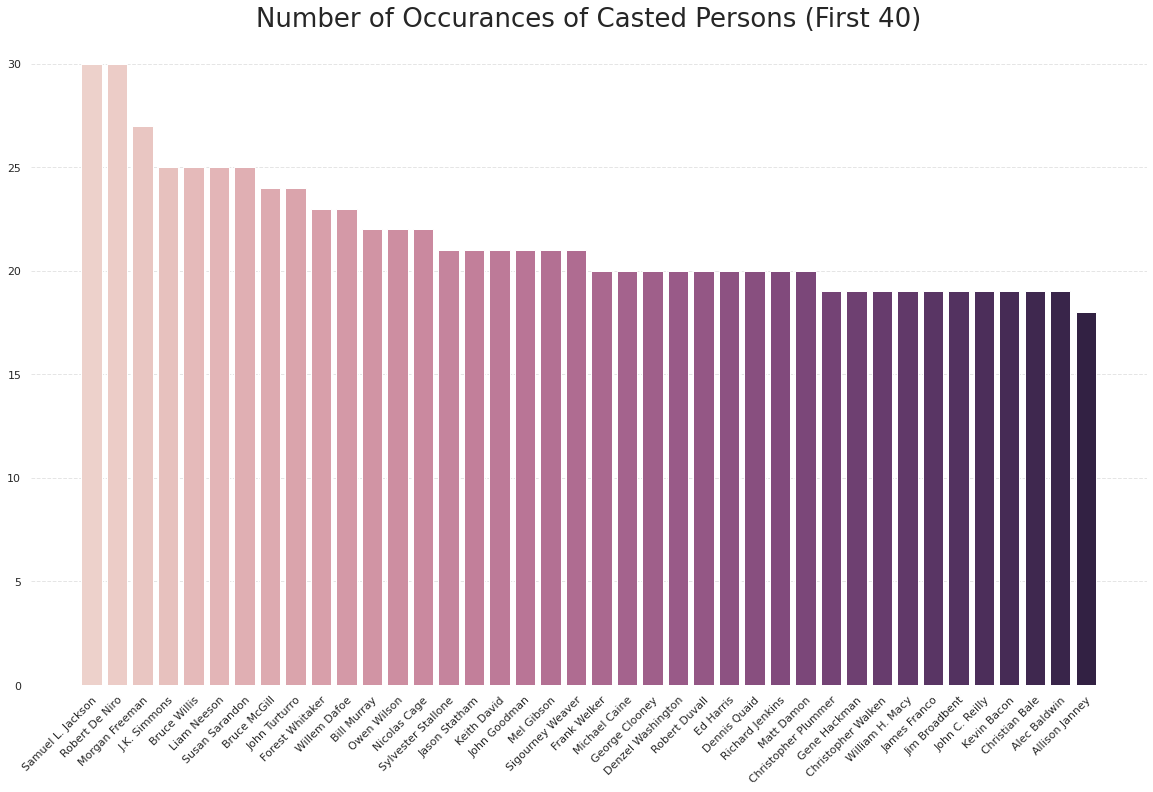

In [1099]:
list_of_cast_names = list(df_train['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
count_casted = Counter([i for j in list_of_cast_names for i in j]).most_common(40)

casted_names = [x[0] for x in count_casted]
occurance_values = [x[1] for x in count_casted]

fig = plt.figure(figsize=(20, 12))

plt.bar(x=casted_names, height=occurance_values, color=sns.cubehelix_palette(n_colors=41))

plt.xticks(rotation=45, rotation_mode="anchor", ha='right')
plt.box(False)
plt.grid(axis='y', alpha=0.5, ls="--")

plt.title("Number of Occurances of Casted Persons (First 40)", size=26)

plt.show();

### Gender

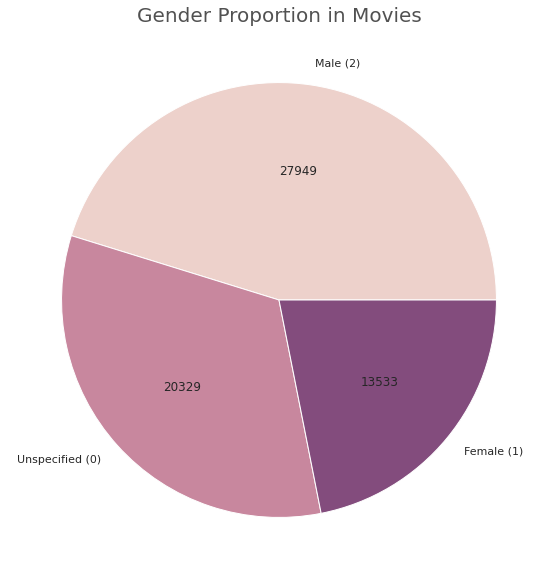

In [1100]:
list_of_cast_genders = list(df_train['cast'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
lst_genders = Counter([i for j in list_of_cast_genders for i in j]).most_common()

idx = ["Male (2)", "Unspecified (0)", "Female (1)"]
vls = np.array([x[1] for x in lst_genders])


def absolute_value(val):
    a  = np.round(val/100.*vls.sum(), 0)
    return int(a)

fig = plt.figure(figsize=(10, 10))

plt.pie(vls, labels=idx, colors=sns.cubehelix_palette(n_colors=4),
        autopct=absolute_value)

plt.title('Gender Proportion in Movies',
          size=20, alpha=0.8)

plt.show();

### Character/Role

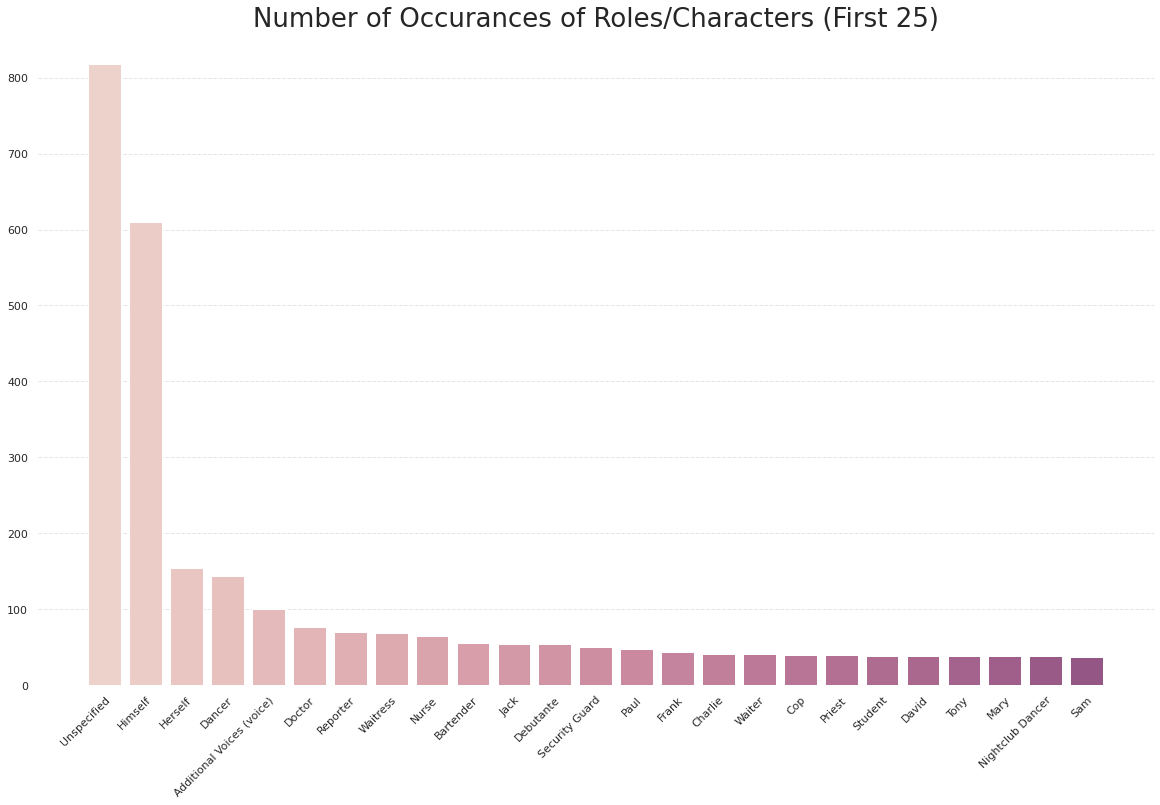

In [1101]:
list_of_cast_characters = list(df_train['cast'].apply(lambda x: [i['character'] for i in x] if x != {} else []).values)
lst_roles = Counter([i for j in list_of_cast_characters for i in j]).most_common(25)

roles_names = [x[0] for x in lst_roles]
occurance_values = [x[1] for x in lst_roles]

roles_names[0] = 'Unspecified'

fig = plt.figure(figsize=(20, 12))

plt.bar(x=roles_names, height=occurance_values, color=sns.cubehelix_palette(n_colors=41))

plt.xticks(rotation=45, rotation_mode="anchor", ha='right')
plt.box(False)
plt.grid(axis='y', alpha=0.5, ls="--")

plt.title("Number of Occurances of Roles/Characters (First 25)", size=26)

plt.show();

### Modifying DataFrames

In [1102]:
top_cast_names = [m[0] for m in Counter([i for j in list_of_cast_names for i in j]).most_common(30)]

def count_most_casted(x):
    count = 0
    for name in top_cast_names:
        if name in str(x):
            count += 1
    return count

df_train['num_30_most_casted'] = df_train['cast'].apply(count_most_casted)
df_test['num_30_most_casted'] = df_test['cast'].apply(count_most_casted)

df_train['num_cast'] = df_train['cast'].apply(lambda x: len(x) if x != {} else 0)
df_test['num_cast'] = df_test['cast'].apply(lambda x: len(x) if x != {} else 0)

df_train['genders_0_cast'] = df_train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
df_train['genders_1_cast'] = df_train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
df_train['genders_2_cast'] = df_train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

df_test['genders_0_cast'] = df_test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
df_test['genders_1_cast'] = df_test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
df_test['genders_2_cast'] = df_test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

In [1103]:
df_train['num_30_most_casted'].unique()

array([0, 1, 2, 3, 4])

# Crew Column

### Crew Members

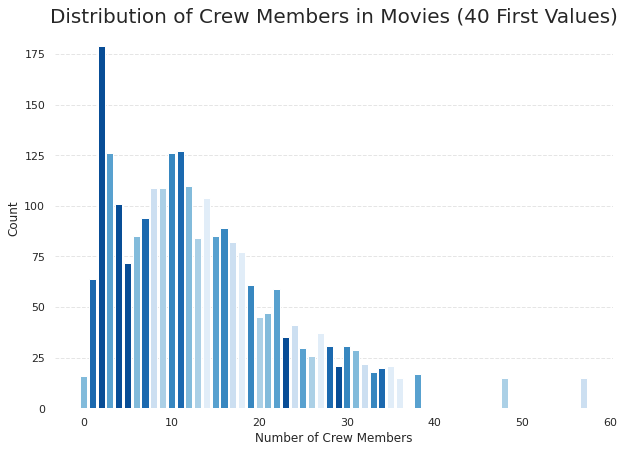

In [1104]:
crew_number = df_train['crew'].apply(lambda x: len(x) if x != {} else 0).value_counts()[:40]

fig = plt.figure(figsize=(10, 7))
plt.bar(x=crew_number.index, height=crew_number.values, color=sns.color_palette("Blues_r", n_colors=8))

plt.ylabel("Count")
plt.xlabel("Number of Crew Members")
plt.title("Distribution of Crew Members in Movies (40 First Values)", size=20)
plt.box(False)

plt.grid(axis='y', alpha=0.5, ls="--")

plt.show();

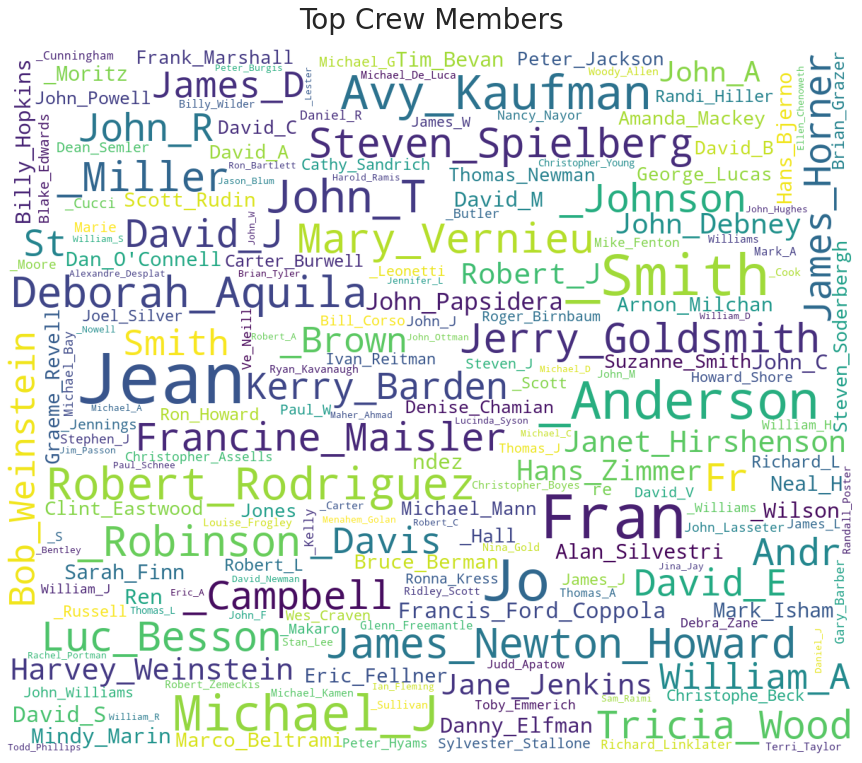

In [1105]:
list_of_crew_names  = list(df_train['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

plt.figure(figsize = (18, 13))

text = ' '.join(['_'.join(i.split(' ')) for j in list_of_crew_names  for i in j])
wordcloud = WordCloud(max_font_size=100, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)

plt.imshow(wordcloud)
plt.title('Top Crew Members', size = 28, y = 1.02)
plt.axis("off")
plt.show()

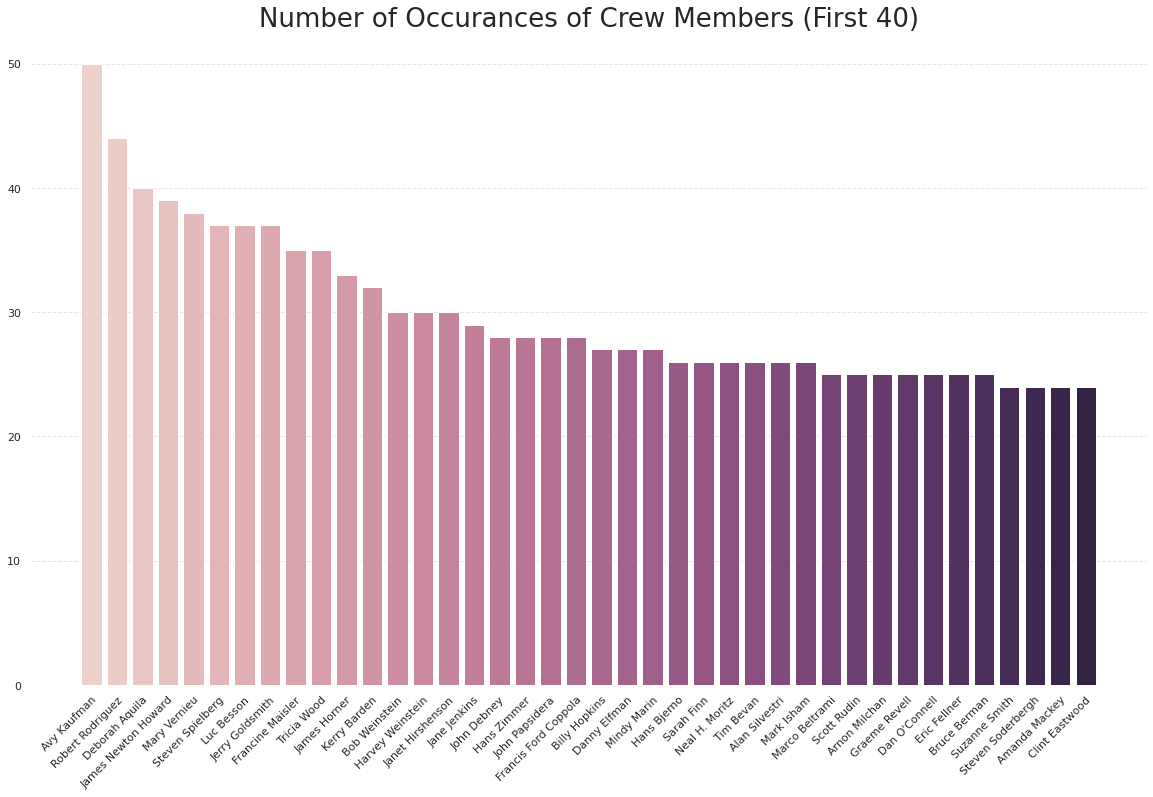

In [1106]:
list_of_crew_names  = list(df_train['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
count_crew = Counter([i for j in list_of_crew_names for i in j]).most_common(40)

crew_names = [x[0] for x in count_crew]
occurance_values = [x[1] for x in count_crew]

fig = plt.figure(figsize=(20, 12))

plt.bar(x=crew_names, height=occurance_values, color=sns.cubehelix_palette(n_colors=41))

plt.xticks(rotation=45, rotation_mode="anchor", ha='right')
plt.box(False)
plt.grid(axis='y', alpha=0.5, ls="--")

plt.title("Number of Occurances of Crew Members (First 40)", size=26)

plt.show();

### Crew Jobs

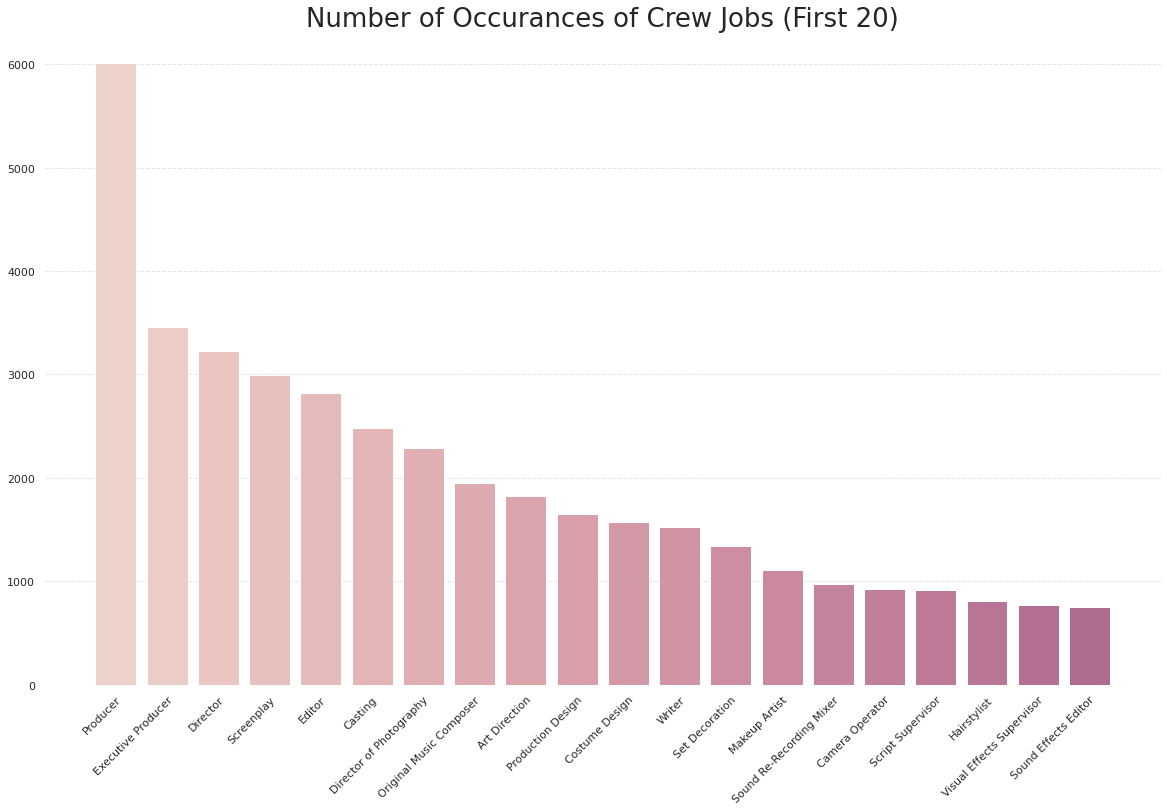

In [1107]:
list_of_crew_jobs = list(df_train['crew'].apply(lambda x: [i['job'] for i in x] if x != {} else []).values)
count_crew_jobs = Counter([i for j in list_of_crew_jobs for i in j]).most_common(20)

crew_jobs = [x[0] for x in count_crew_jobs]
occurance_values = [x[1] for x in count_crew_jobs]

fig = plt.figure(figsize=(20, 12))

plt.bar(x=crew_jobs, height=occurance_values, color=sns.cubehelix_palette(n_colors=41))

plt.xticks(rotation=45, rotation_mode="anchor", ha='right')
plt.box(False)
plt.grid(axis='y', alpha=0.5, ls="--")

plt.title("Number of Occurances of Crew Jobs (First 20)", size=26)

plt.show();

### Crew Departments

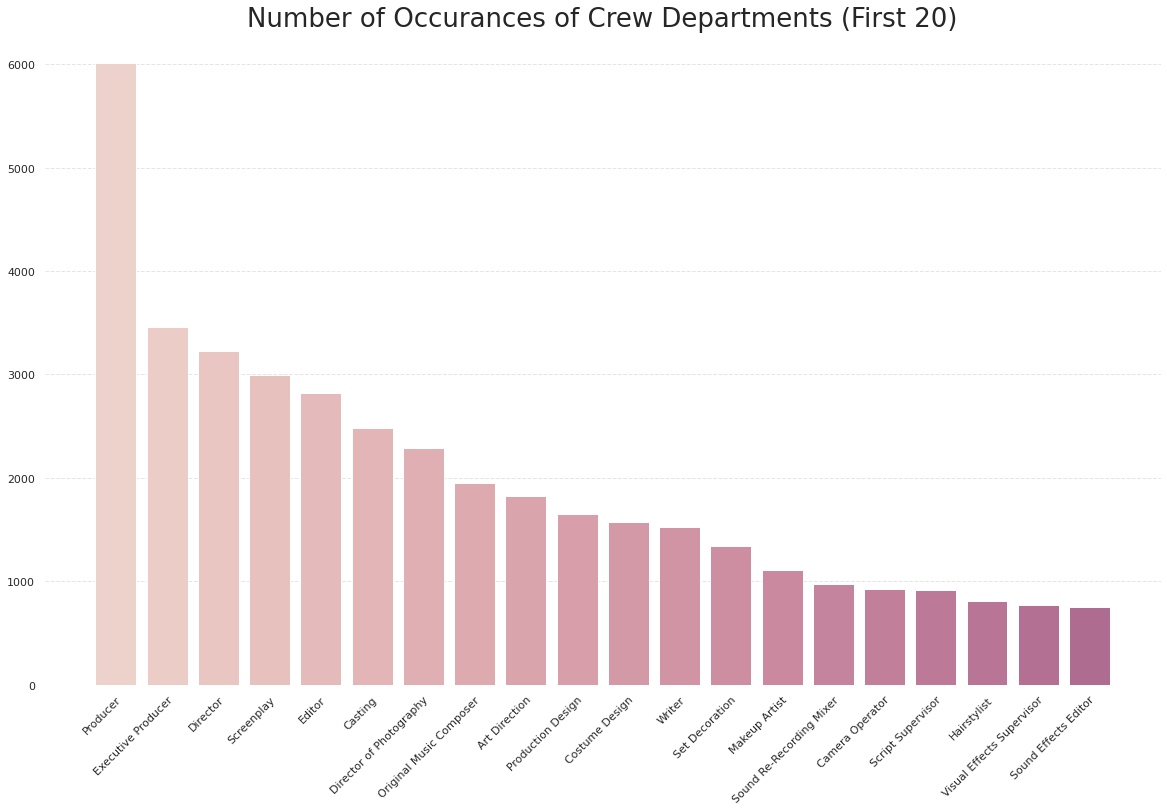

In [1108]:
list_of_crew_departments  = list(df_train['crew'].apply(lambda x: [i['job'] for i in x] if x != {} else []).values)
count_crew_depts = Counter([i for j in list_of_crew_departments  for i in j]).most_common(20)

crew_depts = [x[0] for x in count_crew_depts]
occurance_values = [x[1] for x in count_crew_depts]

fig = plt.figure(figsize=(20, 12))

plt.bar(x=crew_depts, height=occurance_values, color=sns.cubehelix_palette(n_colors=41))

plt.xticks(rotation=45, rotation_mode="anchor", ha='right')
plt.box(False)
plt.grid(axis='y', alpha=0.5, ls="--")

plt.title("Number of Occurances of Crew Departments (First 20)", size=26)

plt.show();

### Crew Gender

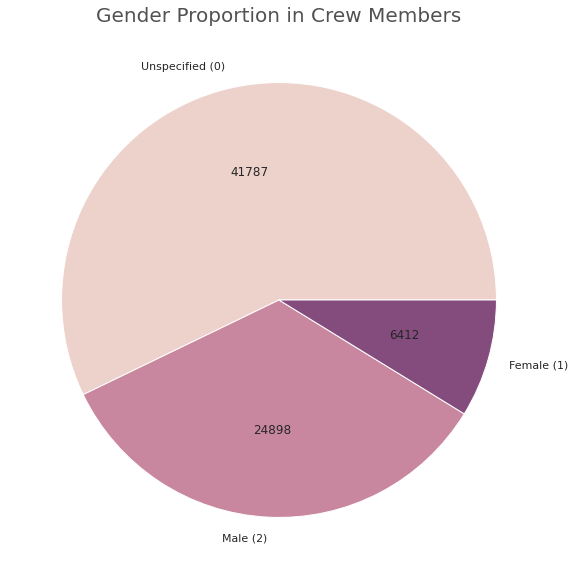

In [1109]:
list_of_crew_genders  = list(df_train['crew'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
lst_genders = Counter([i for j in list_of_crew_genders  for i in j]).most_common()

idx = ["Unspecified (0)", "Male (2)", "Female (1)"]
vls = np.array([x[1] for x in lst_genders])


def absolute_value(val):
    a  = np.round(val/100.*vls.sum(), 0)
    return int(a)

fig = plt.figure(figsize=(10, 10))

plt.pie(vls, labels=idx, colors=sns.cubehelix_palette(n_colors=4),
        autopct=absolute_value)

plt.title('Gender Proportion in Crew Members',
          size=20, alpha=0.8)

plt.show();

### Updating DataFrames

In [1110]:
def count_crew_names(x):
    count = 0
    for name in top_crew_names:
        if name in str(x):
            count += 1
    return count
def count_crew_depts(x):
    count = 0
    for name in top_crew_departments:
        if name in str(x):
            count += 1
    return count

top_crew_names = [m[0] for m in Counter([i for j in list_of_crew_names for i in j]).most_common(30)]
top_crew_departments = [m[0] for m in Counter([i for j in list_of_crew_departments for i in j]).most_common(30)]

df_train['num_30_crew_member'] = df_train['crew'].apply(count_crew_names)
df_test['num_30_crew_member'] = df_test['crew'].apply(count_crew_names)

df_train['num_30_crew_dept'] = df_train['crew'].apply(count_crew_depts)
df_test['num_30_crew_dept'] = df_test['crew'].apply(count_crew_depts)

df_train['genders_0_crew'] = df_train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
df_train['genders_1_crew'] = df_train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
df_train['genders_2_crew'] = df_train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

df_test['genders_0_crew'] = df_test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
df_test['genders_1_crew'] = df_test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
df_test['genders_2_crew'] = df_test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

df_train['num_crew'] = df_train['crew'].apply(lambda x: len(x) if x != {} else 0)
df_test['num_crew'] = df_test['crew'].apply(lambda x: len(x) if x != {} else 0)

In [1111]:
df_train['num_30_crew_member'].unique()

array([0, 1, 2, 3, 5, 4, 6])

In [1112]:
df_train['num_30_crew_dept'].value_counts().index

Int64Index([ 2,  8, 10,  7, 12, 11, 13,  9,  3,  5,  6,  4, 14,  1, 15, 22, 16,
            24, 18, 19, 17, 21, 20, 25, 26, 23, 27,  0, 28, 29],
           dtype='int64')

# EDA

In [1113]:
df_train.head(2)

id  ... num_crew
0   1  ...       72
1   2  ...        9

[2 rows x 42 columns]

In [1114]:
df_test.head(2)

id  ... num_crew
0  3001  ...        2
1  3002  ...        8

[2 rows x 41 columns]

### Target and Budget

The revenue data has high skewness:

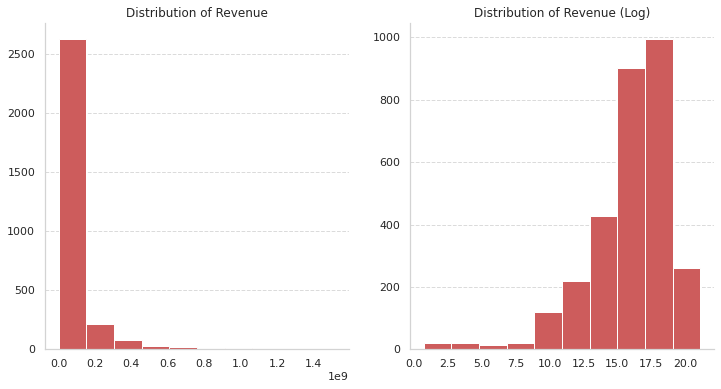

In [1115]:
fig, ax = plt.subplots(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.hist(df_train['revenue'], color='indianred')
plt.title('Distribution of Revenue')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.gca().spines['left'].set_color('lightgray')
plt.gca().spines['bottom'].set_color('lightgray')
plt.grid(axis='y', alpha=0.7, ls="--")

plt.subplot(1, 2, 2)
plt.hist(np.log1p(df_train['revenue']), color='indianred')
plt.title('Distribution of Revenue (Log)')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.gca().spines['left'].set_color('lightgray')
plt.gca().spines['bottom'].set_color('lightgray')
plt.grid(axis='y', alpha=0.7, ls="--")

plt.show();

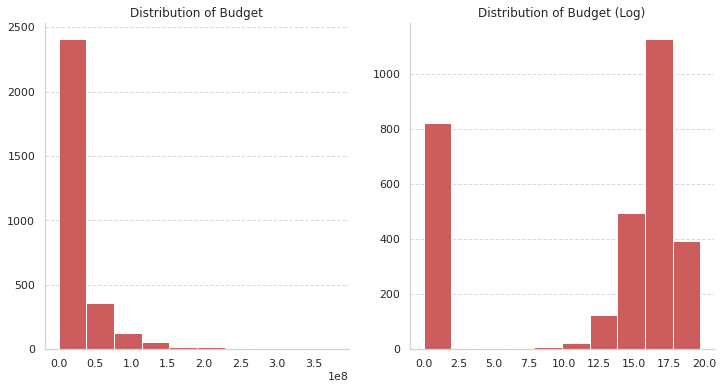

In [1116]:
fig, ax = plt.subplots(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.hist(df_train['budget'], color='indianred')
plt.title('Distribution of Budget')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.gca().spines['left'].set_color('lightgray')
plt.gca().spines['bottom'].set_color('lightgray')
plt.grid(axis='y', alpha=0.7, ls="--")

plt.subplot(1, 2, 2)
plt.hist(np.log1p(df_train['budget']), color='indianred')
plt.title('Distribution of Budget (Log)')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.gca().spines['left'].set_color('lightgray')
plt.gca().spines['bottom'].set_color('lightgray')
plt.grid(axis='y', alpha=0.7, ls="--")

plt.show();

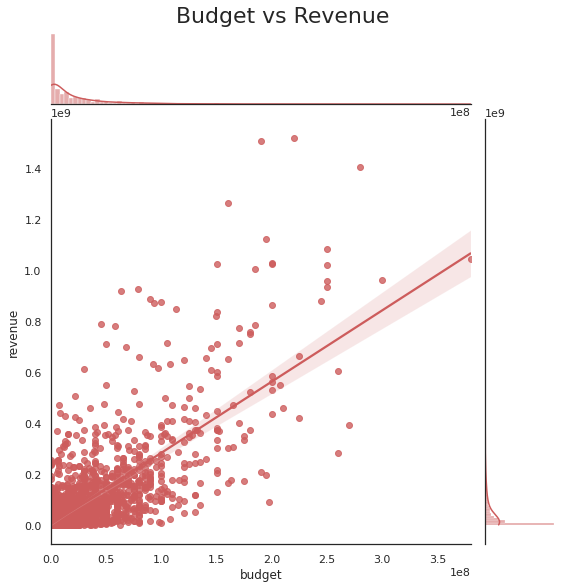

In [1117]:
sns.jointplot(x="budget", y="revenue", kind='reg',data=df_train, color='indianred', height=8)
plt.suptitle("Budget vs Revenue", size=22, y=1.02)
plt.show();

In [1118]:
df_train['log_budget'] = np.log1p(df_train['budget'])
df_test['log_budget'] = np.log1p(df_test['budget'])

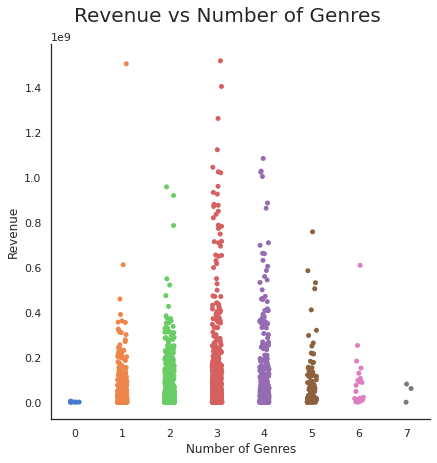

In [1119]:
ax = sns.catplot(x='num_genres', y='revenue', data=df_train, height=6)
plt.suptitle('Revenue vs Number of Genres', size=20, y=1.03)
ax.set_axis_labels("Number of Genres", "Revenue")
plt.show();

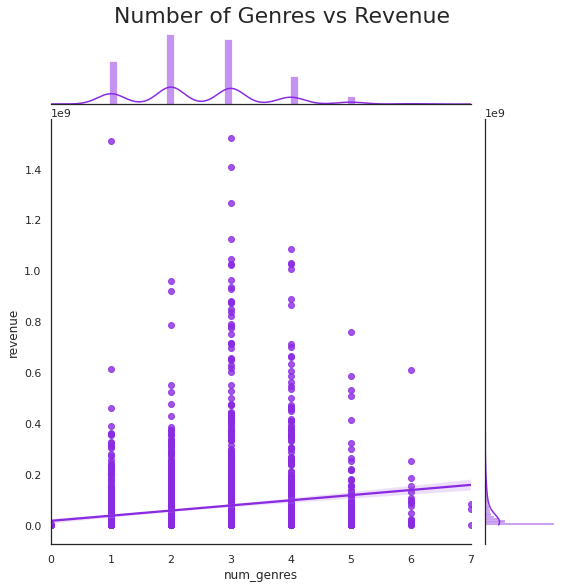

In [1120]:
sns.jointplot(x="num_genres", y="revenue", kind='reg',data=df_train, color='blueviolet', height=8)
plt.suptitle("Number of Genres vs Revenue", size=22, y=1.02)
plt.show();

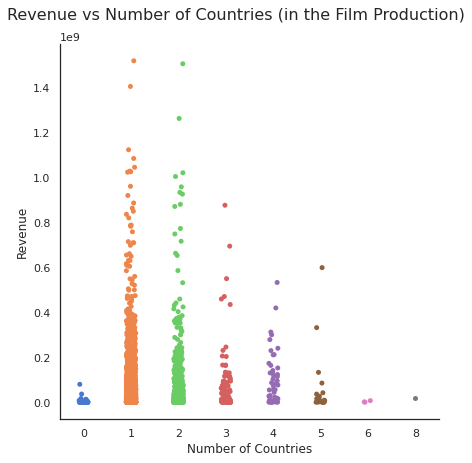

In [1121]:
ax = sns.catplot(x='num_countries', y='revenue', data=df_train, height=6)
plt.suptitle('Revenue vs Number of Countries (in the Film Production)', size=16, y=1.03)
ax.set_axis_labels("Number of Countries", "Revenue")
plt.show();

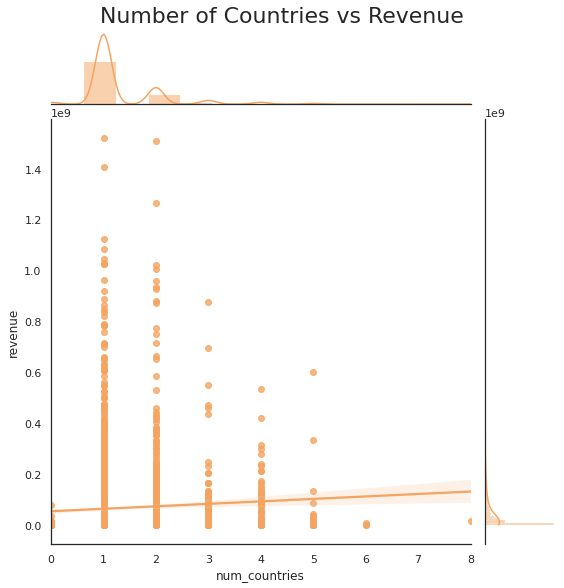

In [1122]:
sns.jointplot(x="num_countries", y="revenue", kind='reg',data=df_train, color='sandybrown', height=8)
plt.suptitle("Number of Countries vs Revenue", size=22, y=1.02)
plt.show();

In [1123]:
df_train['log_revenue'] = np.log1p(df_train['revenue'])

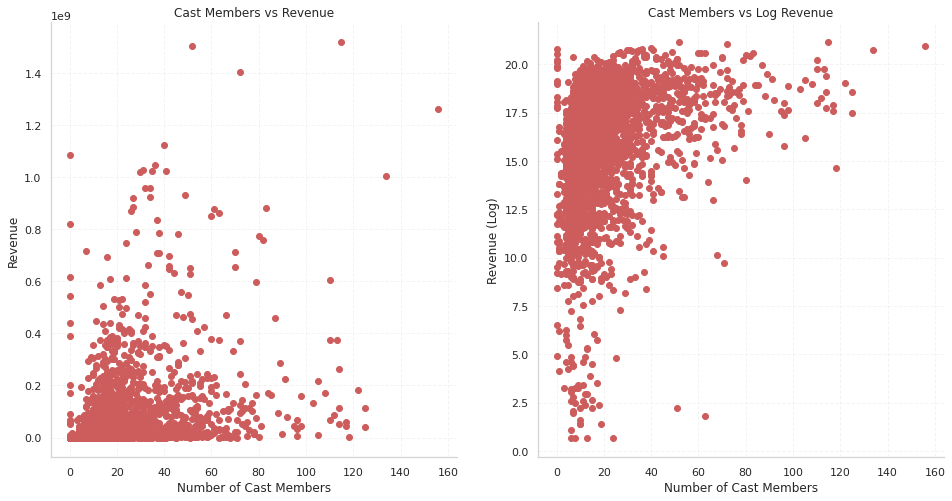

In [1124]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.scatter(df_train['num_cast'], df_train['revenue'], color='indianred')
plt.title('Cast Members vs Revenue')
plt.ylabel("Revenue")
plt.xlabel("Number of Cast Members")
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.gca().spines['left'].set_color('lightgray')
plt.gca().spines['bottom'].set_color('lightgray')
plt.grid(axis='both', alpha=0.2, ls="--")

plt.subplot(1, 2, 2)
plt.scatter(df_train['num_cast'], df_train['log_revenue'], color='indianred')
plt.title('Cast Members vs Log Revenue')
plt.ylabel("Revenue (Log)")
plt.xlabel("Number of Cast Members")
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.gca().spines['left'].set_color('lightgray')
plt.gca().spines['bottom'].set_color('lightgray')
plt.grid(axis='both', alpha=0.2, ls="--")

plt.show()

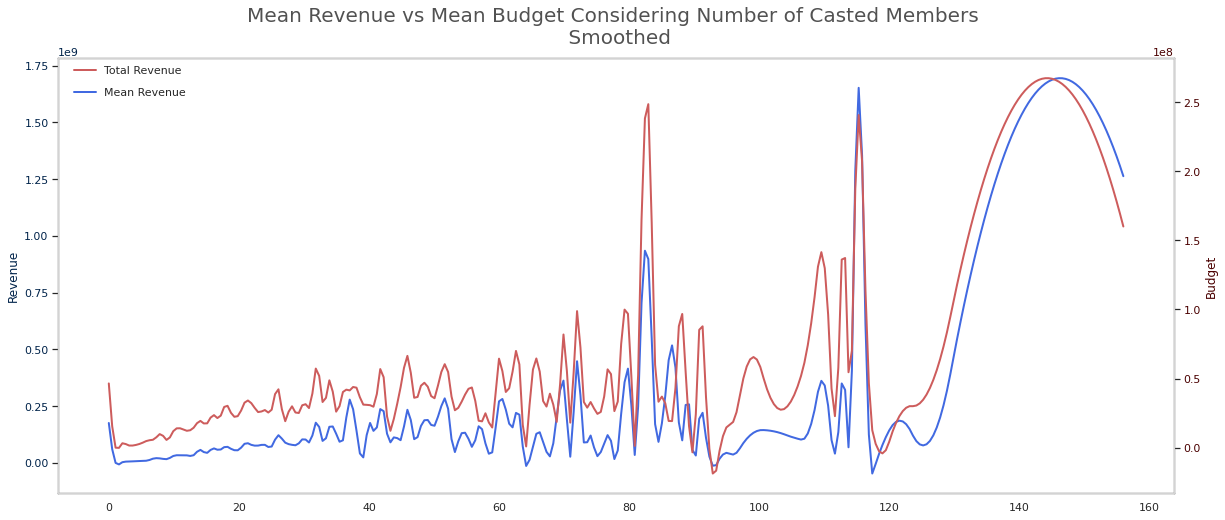

In [1125]:
mean_num_cast_revenue = df_train.groupby(['num_cast'])['revenue'].mean()
mean_num_cast_budget = df_train.groupby(['num_cast'])['budget'].mean()


mean_revenue_x = np.linspace(mean_num_cast_revenue.index.min(), 
                             mean_num_cast_revenue.index.max(), 300)

mean_budget_x = np.linspace(mean_num_cast_budget.index.min(), 
                             mean_num_cast_budget.index.max(), 300)


x = make_interp_spline(mean_num_cast_revenue.index, mean_num_cast_revenue.values, k = 2)
smooth_revenue = x(mean_revenue_x)

x = make_interp_spline(mean_num_cast_budget.index,mean_num_cast_budget.values, k = 2)
smooth_budget = x(mean_budget_x)


fig, ax1 = plt.subplots(figsize=(20, 8))

ax1.set_ylabel('Revenue', color='#00234a')
ax1.plot(mean_revenue_x, smooth_revenue, 
         color='royalblue', lw=2, label="Mean Revenue")
ax1.tick_params(axis='y', labelcolor='#00234a')

ax2 = ax1.twinx()

ax2.set_ylabel('Budget', color='#4a0000')
ax2.plot(mean_budget_x, smooth_budget, 
         color='indianred', lw=2, label="Total Revenue")
ax2.tick_params(axis='y', labelcolor='#4a0000')

plt.gca().spines['right'].set_color('lightgray')
plt.gca().spines['top'].set_color('lightgray')
plt.gca().spines['left'].set_color('lightgray')
plt.gca().spines['bottom'].set_color('lightgray')

plt.title('Mean Revenue vs Mean Budget Considering Number of Casted Members \n Smoothed',
          size=20, alpha=0.8, y=1.02)

ax1.legend(loc = (.01,.9), frameon = False)
ax2.legend(loc = (.01,.95), frameon = False)

plt.show();

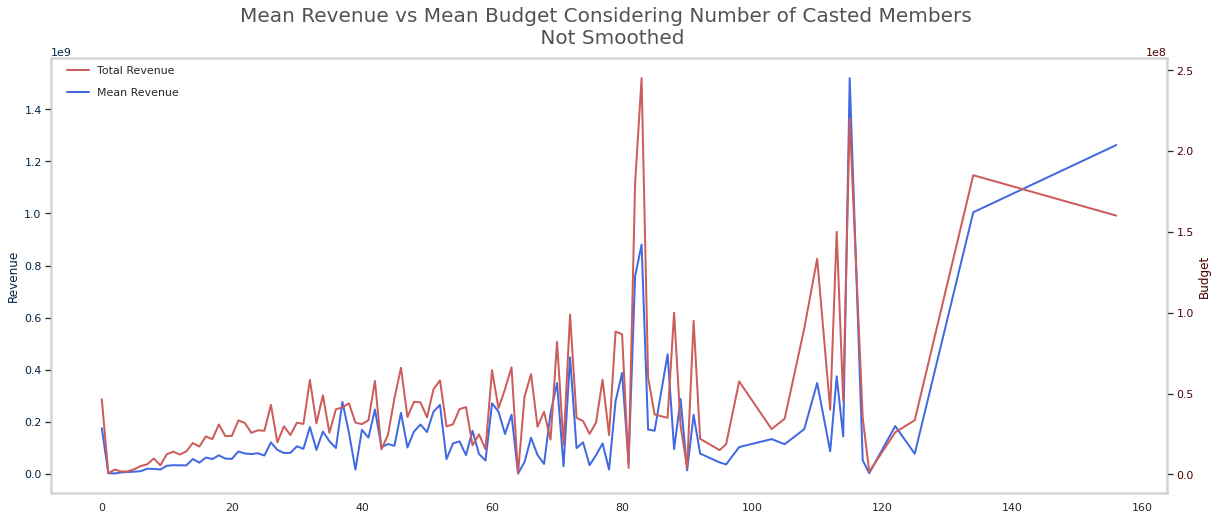

In [1126]:
mean_num_cast_revenue = df_train.groupby(['num_cast'])['revenue'].mean()
mean_num_cast_budget = df_train.groupby(['num_cast'])['budget'].mean()

fig, ax1 = plt.subplots(figsize=(20, 8))

ax1.set_ylabel('Revenue', color='#00234a')
ax1.plot(mean_num_cast_revenue.index, mean_num_cast_revenue.values, 
         color='royalblue', lw=2, label="Mean Revenue")
ax1.tick_params(axis='y', labelcolor='#00234a')

ax2 = ax1.twinx()

ax2.set_ylabel('Budget', color='#4a0000')
ax2.plot(mean_num_cast_budget.index, mean_num_cast_budget.values, 
         color='indianred', lw=2, label="Total Revenue")
ax2.tick_params(axis='y', labelcolor='#4a0000')

plt.gca().spines['right'].set_color('lightgray')
plt.gca().spines['top'].set_color('lightgray')
plt.gca().spines['left'].set_color('lightgray')
plt.gca().spines['bottom'].set_color('lightgray')

plt.title('Mean Revenue vs Mean Budget Considering Number of Casted Members \n Not Smoothed',
          size=20, alpha=0.8, y=1.02)

ax1.legend(loc = (.01,.9), frameon = False)
ax2.legend(loc = (.01,.95), frameon = False)

plt.show();

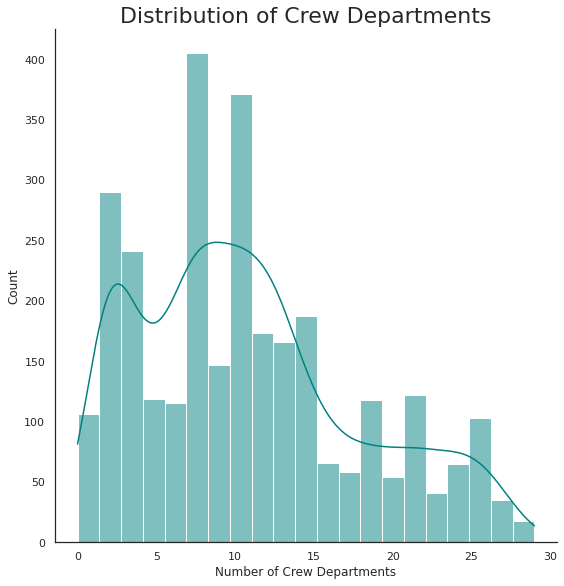

In [1127]:
ax = sns.displot(df_train.num_30_crew_dept, height=8, kde=True, color='teal');
ax.set_axis_labels("Number of Crew Departments")
plt.title("Distribution of Crew Departments", size=22)
plt.show();

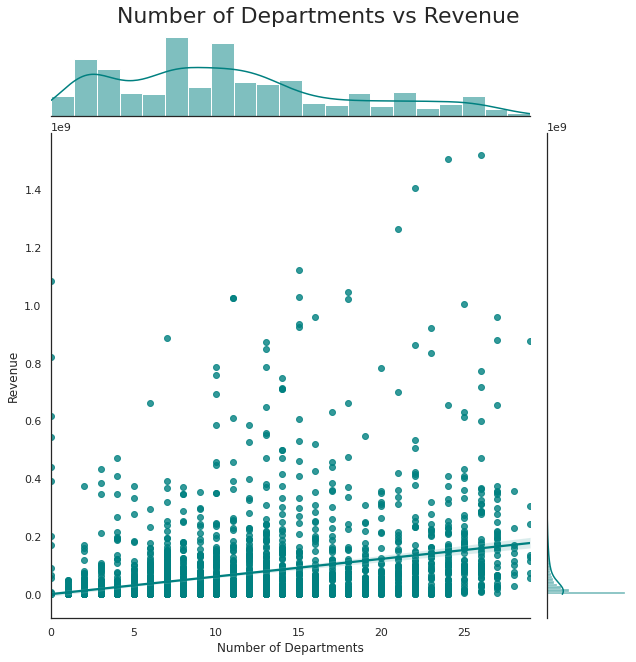

In [1128]:
ax = sns.jointplot(x="num_30_crew_dept", y="revenue", kind='reg',data=df_train, color='teal', height=9)
plt.suptitle("Number of Departments vs Revenue", size=22, y=1.02)
ax.set_axis_labels("Number of Departments", "Revenue")
plt.show();

### Homepage Column

In [1129]:
df_train['homepage'].shape

(3000,)

In [1130]:
df_train['homepage'].isna().sum()

2054

In [1131]:
df_train['has_homepage'] = 0
df_train.loc[df_train['homepage'].isnull() == False, 'has_homepage'] = 1

df_test['has_homepage'] = 0
df_test.loc[df_test['homepage'].isnull() == False, 'has_homepage'] = 1

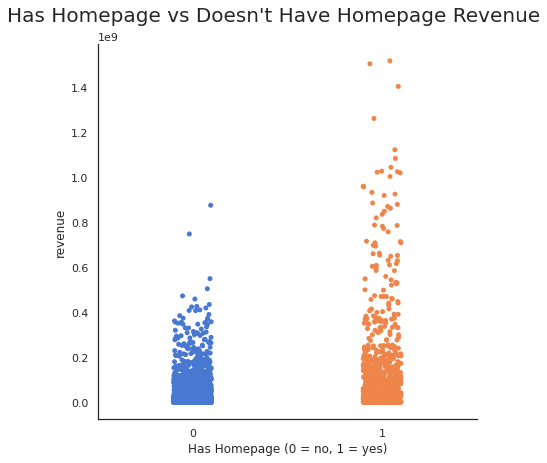

In [1132]:
ax = sns.catplot(x='has_homepage', y='revenue', data=df_train, height=6)
plt.suptitle("Has Homepage vs Doesn't Have Homepage Revenue", size=20, y=1.03)
ax.set_axis_labels("Has Homepage (0 = no, 1 = yes)")
plt.show();

## ```original_language``` Column

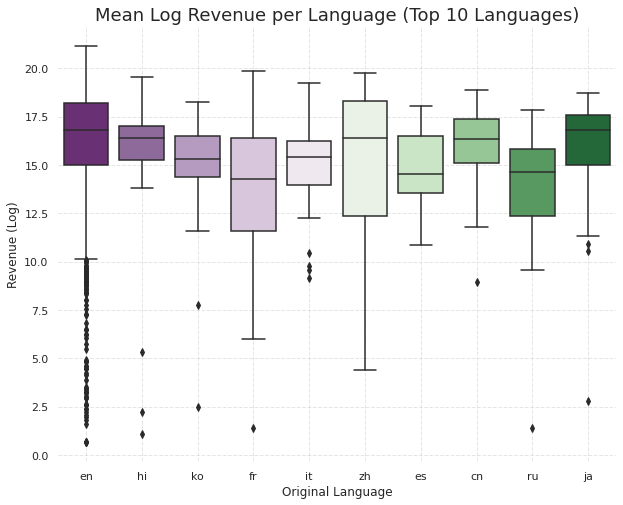

In [1133]:
fig = plt.figure(figsize = (10, 8))
df_plot_lang_rev = df_train.loc[df_train['original_language'].isin(df_train['original_language'].value_counts().head(10).index)]
sns.boxplot(x='original_language', y='log_revenue', data=df_plot_lang_rev, palette=sns.color_palette("PRGn", n_colors=10));

plt.title("Mean Log Revenue per Language (Top 10 Languages)", size = 18)
plt.xlabel("Original Language")
plt.ylabel("Revenue (Log)")

plt.grid(axis='both', alpha=0.5, ls="--")
plt.box(False)

plt.show();

## ```popularity``` Column

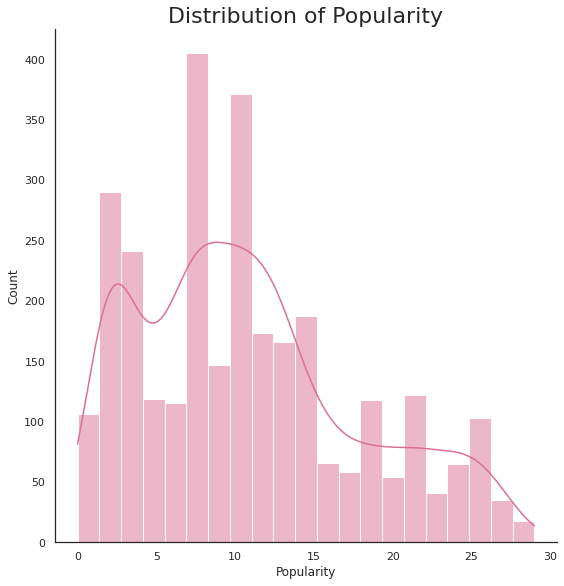

In [1134]:
ax = sns.displot(df_train.num_30_crew_dept, height=8, kde=True, color='palevioletred');
ax.set_axis_labels("Popularity")
plt.title("Distribution of Popularity", size=22)
plt.show();

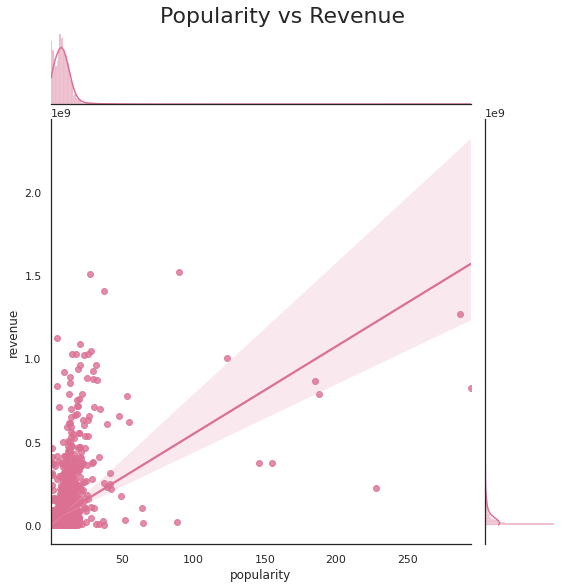

In [1135]:
sns.jointplot(x="popularity", y="revenue", kind='reg',data=df_train, color='palevioletred', height=8)
plt.suptitle("Popularity vs Revenue", size=22, y=1.02)
plt.show();

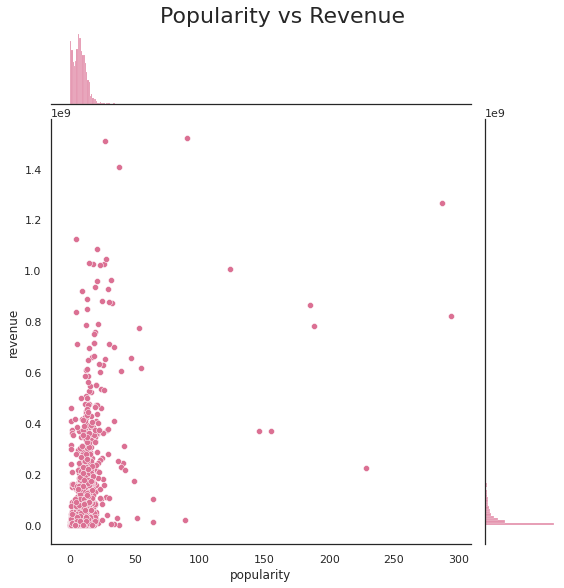

In [1136]:
sns.jointplot(x="popularity", y="revenue", kind='scatter',data=df_train, color='palevioletred', height=8)
plt.suptitle("Popularity vs Revenue", size=22, y=1.02)
plt.show();

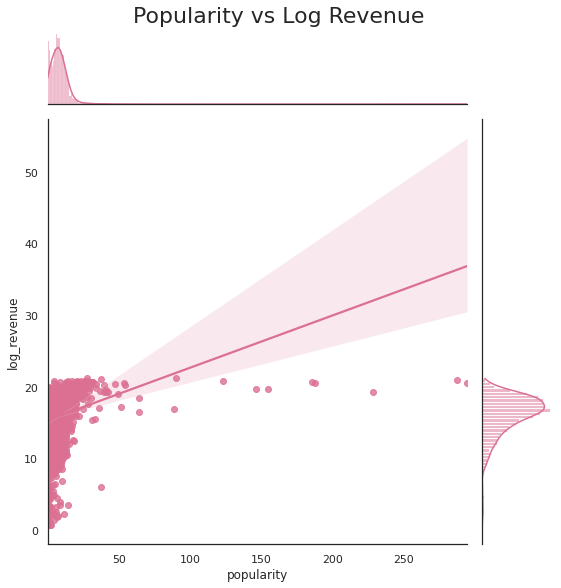

In [1137]:
sns.jointplot(x="popularity", y="log_revenue", kind='reg',data=df_train, color='palevioletred', height=8)
plt.suptitle("Popularity vs Log Revenue", size=22, y=1.02)
plt.show();

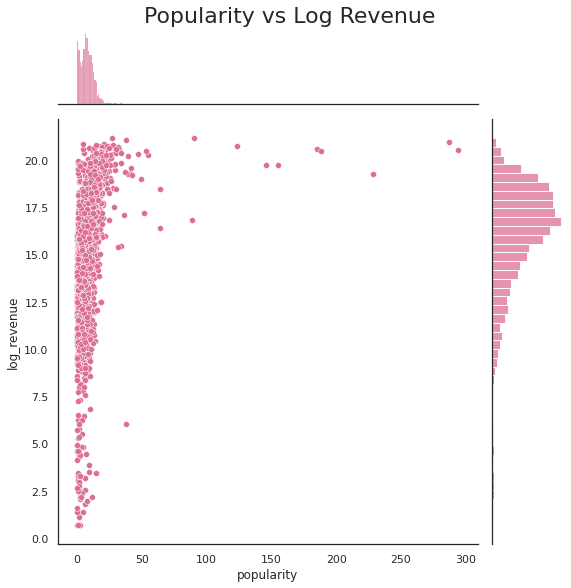

In [1138]:
sns.jointplot(x="popularity", y="log_revenue", kind='scatter',data=df_train, color='palevioletred', height=8)
plt.suptitle("Popularity vs Log Revenue", size=22, y=1.02)
plt.show();

##```release_date``` Column

### Filling Missing Value

In [1139]:
df_train['release_date'].isna().sum()

0

In [1140]:
df_test['release_date'].isna().sum()

1

In [1141]:
df_test[df_test['release_date'].isna()]

id belongs_to_collection  budget  ... num_crew log_budget has_homepage
828  3829                    {}       0  ...        0        0.0            0

[1 rows x 43 columns]

The movie was released in May 5, 2000[1](https://www.rottentomatoes.com/m/jails_hospitals_and_hip_hop).

In [1142]:
df_test.loc[df_test['release_date'].isna() == True, 'release_date'] = '05/05/00'

### Change Date Structure

In [1143]:
def add_full_year(x):
    """
    Change from 15 to 2015, and 98 to 1998
    """
    year = x.split('/')[2]
    if int(year) <= 19:
        return x[:-2] + '20' + year
    else:
        return x[:-2] + '19' + year

df_train['release_date'] = df_train['release_date'].apply(lambda x: add_full_year(x))
df_test['release_date'] = df_test['release_date'].apply(lambda x: add_full_year(x))

In [1144]:
df_train['release_date'].head()

0     2/20/2015
1      8/6/2004
2    10/10/2014
3      3/9/2012
4      2/5/2009
Name: release_date, dtype: object

In [1145]:
df_train['release_date'] = pd.to_datetime(df_train['release_date'])
df_test['release_date'] = pd.to_datetime(df_test['release_date'])

In [1146]:
df_train['release_date'].head()

0   2015-02-20
1   2004-08-06
2   2014-10-10
3   2012-03-09
4   2009-02-05
Name: release_date, dtype: datetime64[ns]

### Splitting Date

In [1147]:
# creating features based on dates
def splitdate(df):
    date_parts = ["year", "month", "day", "weekday", "quarter"]
    for part in date_parts:
        part_col = 'release_date' + "_" + part
        df[part_col] = getattr(df['release_date'].dt, part).astype(int)
    
    return df

df_train = splitdate(df_train)
df_test = splitdate(df_test)

In [1148]:
df_train.head(3)

id  ... release_date_quarter
0   1  ...                    1
1   2  ...                    3
2   3  ...                    4

[3 rows x 50 columns]

### Movies Per Year

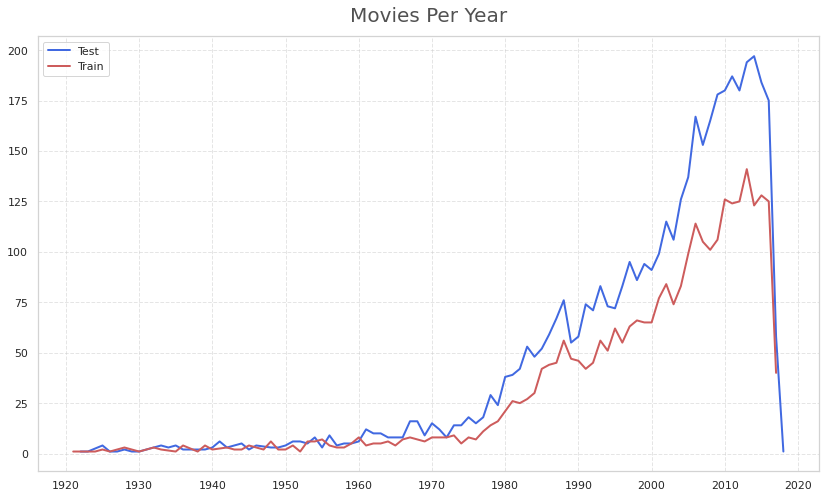

In [1149]:
films_per_year_train = df_train.groupby('release_date_year')['id'].count()
films_per_year_test = df_test.groupby('release_date_year')['id'].count()

fig = plt.figure(figsize=(14, 8))

plt.plot(films_per_year_test.index, films_per_year_test.values, 
         color='royalblue', lw=2, label='Test')
plt.plot(films_per_year_train.index, films_per_year_train.values, 
         color='indianred', lw=2, label='Train')



plt.xticks([x for x in range(1920, 2030, 10)])

plt.gca().spines['right'].set_color('lightgray')
plt.gca().spines['top'].set_color('lightgray')
plt.gca().spines['left'].set_color('lightgray')
plt.gca().spines['bottom'].set_color('lightgray')
plt.grid(axis='both', alpha=0.5, ls="--")

plt.title('Movies Per Year',
          size=20, alpha=0.8, y=1.02)

plt.legend()

plt.show();

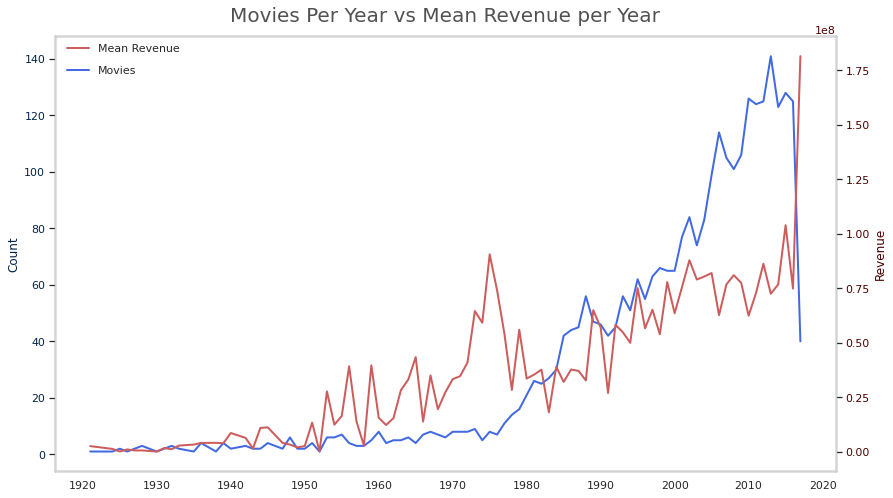

In [1150]:
revenue_per_year = df_train.groupby(['release_date_year'])['revenue'].mean()
films_per_year_train = df_train.groupby('release_date_year')['id'].count()

#fig = plt.figure(figsize=(14, 8))
fig, ax1 = plt.subplots(figsize=(14, 8))


ax1.set_ylabel('Count', color='#00234a')
ax1.plot(films_per_year_train.index, films_per_year_train.values, 
         color='royalblue', lw=2, label='Movies')
ax1.tick_params(axis='y', labelcolor='#00234a')


ax2 = ax1.twinx()

ax2.set_ylabel('Revenue', color='#4a0000')
ax2.plot(revenue_per_year.index, revenue_per_year.values, 
         color='indianred', lw=2, label='Mean Revenue')
ax2.tick_params(axis='y', labelcolor='#4a0000')


plt.xticks([x for x in range(1920, 2030, 10)])

plt.gca().spines['right'].set_color('lightgray')
plt.gca().spines['top'].set_color('lightgray')
plt.gca().spines['left'].set_color('lightgray')
plt.gca().spines['bottom'].set_color('lightgray')

plt.title('Movies Per Year vs Mean Revenue per Year',
          size=20, alpha=0.8, y=1.02)

ax1.legend(loc = (.01,.9), frameon = False)
ax2.legend(loc = (.01,.95), frameon = False)

plt.show();

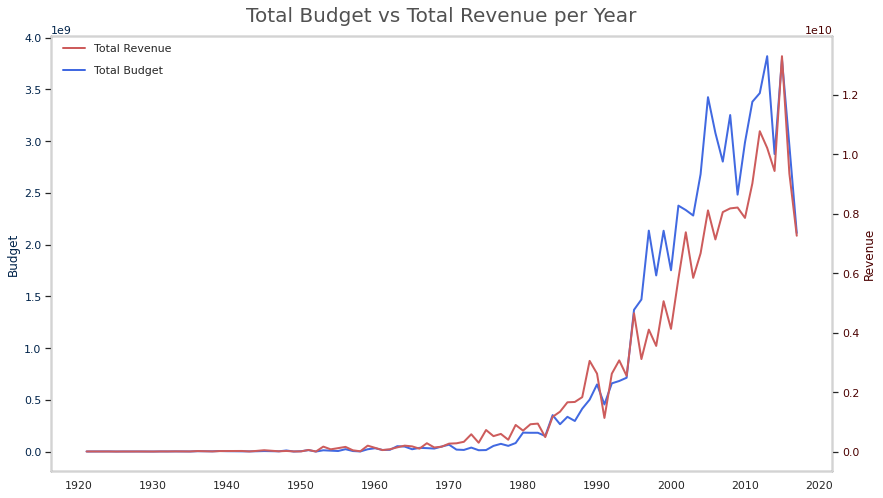

In [1151]:
revenue_per_year = df_train.groupby(['release_date_year'])['revenue'].sum()
budget_per_year = df_train.groupby(['release_date_year'])['budget'].sum()

#fig = plt.figure(figsize=(14, 8))
fig, ax1 = plt.subplots(figsize=(14, 8))


ax1.set_ylabel('Budget', color='#00234a')
ax1.plot(budget_per_year.index, budget_per_year.values, 
         color='royalblue', lw=2, label='Total Budget')
ax1.tick_params(axis='y', labelcolor='#00234a')


ax2 = ax1.twinx()

ax2.set_ylabel('Revenue', color='#4a0000')
ax2.plot(revenue_per_year.index, revenue_per_year.values, 
         color='indianred', lw=2, label='Total Revenue')
ax2.tick_params(axis='y', labelcolor='#4a0000')


plt.xticks([x for x in range(1920, 2030, 10)])

plt.gca().spines['right'].set_color('lightgray')
plt.gca().spines['top'].set_color('lightgray')
plt.gca().spines['left'].set_color('lightgray')
plt.gca().spines['bottom'].set_color('lightgray')

plt.title('Total Budget vs Total Revenue per Year',
          size=20, alpha=0.8, y=1.02)

ax1.legend(loc = (.01,.9), frameon = False)
ax2.legend(loc = (.01,.95), frameon = False)

plt.show();

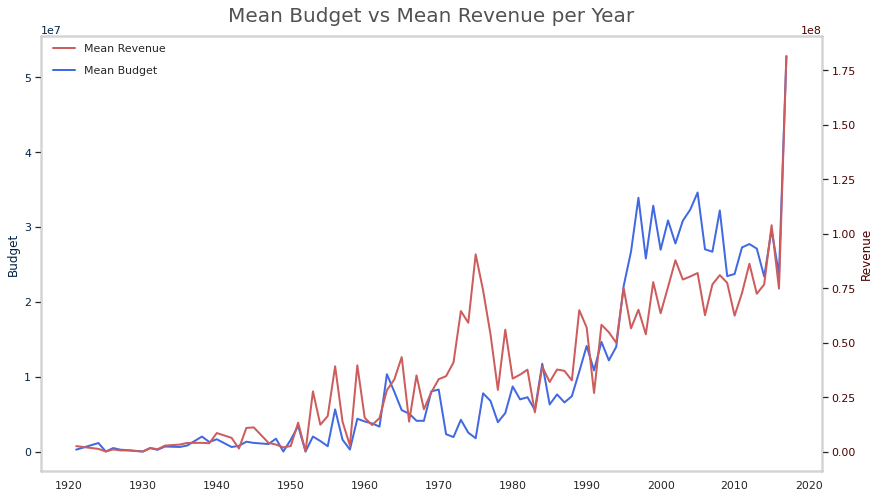

In [1152]:
revenue_per_year = df_train.groupby(['release_date_year'])['revenue'].mean()
budget_per_year = df_train.groupby(['release_date_year'])['budget'].mean()

#fig = plt.figure(figsize=(14, 8))
fig, ax1 = plt.subplots(figsize=(14, 8))


ax1.set_ylabel('Budget', color='#00234a')
ax1.plot(budget_per_year.index, budget_per_year.values, 
         color='royalblue', lw=2, label='Mean Budget')
ax1.tick_params(axis='y', labelcolor='#00234a')


ax2 = ax1.twinx()

ax2.set_ylabel('Revenue', color='#4a0000')
ax2.plot(revenue_per_year.index, revenue_per_year.values, 
         color='indianred', lw=2, label='Mean Revenue')
ax2.tick_params(axis='y', labelcolor='#4a0000')


plt.xticks([x for x in range(1920, 2030, 10)])

plt.gca().spines['right'].set_color('lightgray')
plt.gca().spines['top'].set_color('lightgray')
plt.gca().spines['left'].set_color('lightgray')
plt.gca().spines['bottom'].set_color('lightgray')

plt.title('Mean Budget vs Mean Revenue per Year',
          size=20, alpha=0.8, y=1.02)

ax1.legend(loc = (.01,.9), frameon = False)
ax2.legend(loc = (.01,.95), frameon = False)

plt.show();

### Movies per Weekday

In [1153]:
df_train.head(1)

id  ... release_date_quarter
0   1  ...                    1

[1 rows x 50 columns]

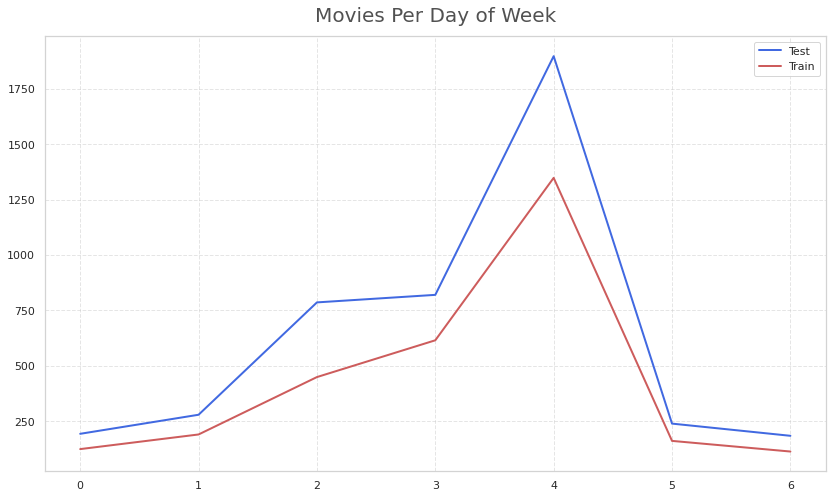

In [1154]:
films_per_weekday_train = df_train.groupby('release_date_weekday')['id'].count()
films_per_weekday_test = df_test.groupby('release_date_weekday')['id'].count()

fig = plt.figure(figsize=(14, 8))

plt.plot(films_per_weekday_test.index, films_per_weekday_test.values, 
         color='royalblue', lw=2, label='Test')
plt.plot(films_per_weekday_train.index, films_per_weekday_train.values, 
         color='indianred', lw=2, label='Train')



plt.gca().spines['right'].set_color('lightgray')
plt.gca().spines['top'].set_color('lightgray')
plt.gca().spines['left'].set_color('lightgray')
plt.gca().spines['bottom'].set_color('lightgray')
plt.grid(axis='both', alpha=0.5, ls="--")

plt.title('Movies Per Day of Week',
          size=20, alpha=0.8, y=1.02)

plt.legend()

plt.show();

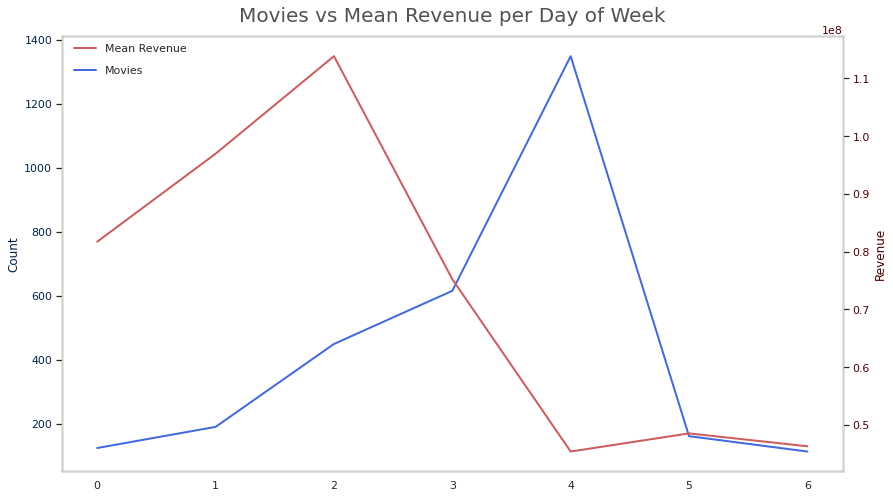

In [1155]:
revenue_per_weekday = df_train.groupby('release_date_weekday')['revenue'].mean()
films_per_weekday_train = df_train.groupby('release_date_weekday')['id'].count()

#fig = plt.figure(figsize=(14, 8))
fig, ax1 = plt.subplots(figsize=(14, 8))


ax1.set_ylabel('Count', color='#00234a')
ax1.plot(films_per_weekday_train.index, films_per_weekday_train.values, 
         color='royalblue', lw=2, label='Movies')
ax1.tick_params(axis='y', labelcolor='#00234a')


ax2 = ax1.twinx()

ax2.set_ylabel('Revenue', color='#4a0000')
ax2.plot(revenue_per_weekday.index, revenue_per_weekday.values, 
         color='indianred', lw=2, label='Mean Revenue')
ax2.tick_params(axis='y', labelcolor='#4a0000')


plt.gca().spines['right'].set_color('lightgray')
plt.gca().spines['top'].set_color('lightgray')
plt.gca().spines['left'].set_color('lightgray')
plt.gca().spines['bottom'].set_color('lightgray')

plt.title('Movies vs Mean Revenue per Day of Week',
          size=20, alpha=0.8, y=1.02)

ax1.legend(loc = (.01,.9), frameon = False)
ax2.legend(loc = (.01,.95), frameon = False)

plt.show();

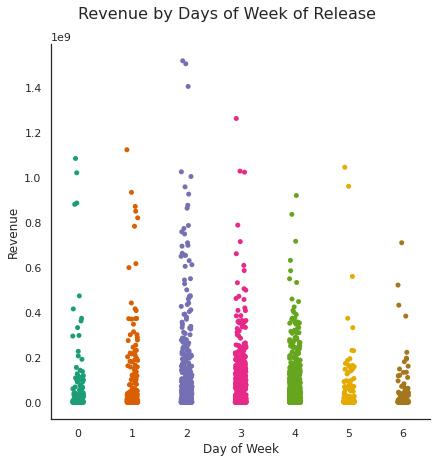

In [1156]:
ax = sns.catplot(x='release_date_weekday', y='revenue', data=df_train, height=6, palette=sns.color_palette("Dark2", n_colors=7));
plt.suptitle("Revenue by Days of Week of Release", size=16, y=1.03)
ax.set_axis_labels("Day of Week", "Revenue")
plt.show();

### Quarter of Release

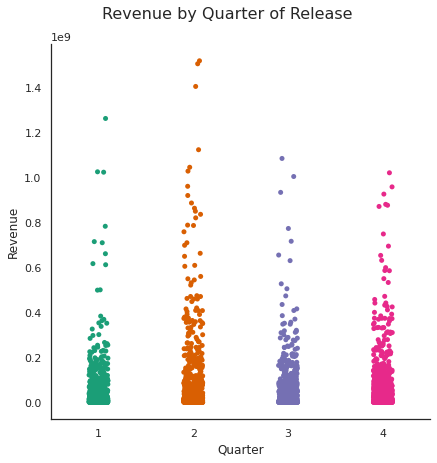

In [1157]:
ax = sns.catplot(x='release_date_quarter', y='revenue', data=df_train, height=6, palette=sns.color_palette("Dark2", n_colors=4));
plt.suptitle("Revenue by Quarter of Release", size=16, y=1.03)
ax.set_axis_labels("Quarter", "Revenue")
plt.show();

### Month of Release

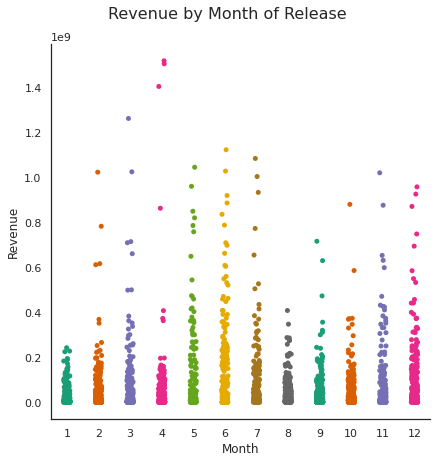

In [1158]:
ax = sns.catplot(x='release_date_month', y='revenue', data=df_train, height=6, palette=sns.color_palette("Dark2", n_colors=12));
plt.suptitle("Revenue by Month of Release", size=16, y=1.03)
ax.set_axis_labels("Month", "Revenue")
plt.show();

## ```runtime``` Column

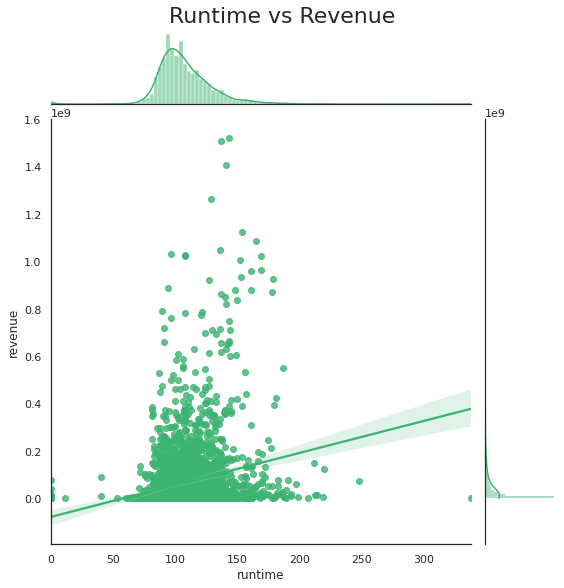

In [1159]:
sns.jointplot(x="runtime", y="revenue", kind='reg',data=df_train, color='mediumseagreen', height=8)
plt.suptitle("Runtime vs Revenue", size=22, y=1.02)
plt.show();

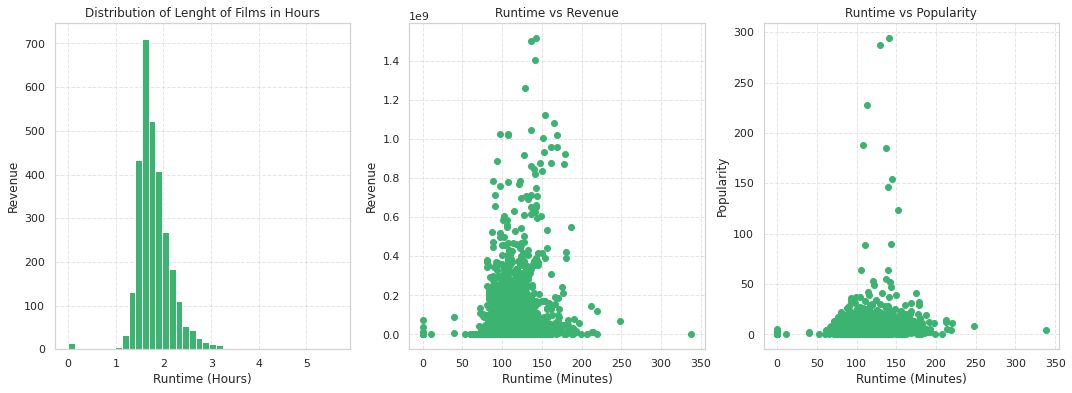

In [1160]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.hist(df_train['runtime'].fillna(0) / 60, bins=40, color='mediumseagreen')
plt.xlabel("Runtime (Hours)")
plt.ylabel("Revenue")
plt.gca().spines['right'].set_color('lightgray')
plt.gca().spines['top'].set_color('lightgray')
plt.gca().spines['left'].set_color('lightgray')
plt.gca().spines['bottom'].set_color('lightgray')
plt.grid(axis='both', alpha=0.5, ls="--")
plt.title('Distribution of Lenght of Films in Hours')

plt.subplot(1, 3, 2)
plt.scatter(df_train['runtime'].fillna(0), df_train['revenue'], color='mediumseagreen')
plt.xlabel("Runtime (Minutes)")
plt.ylabel("Revenue")
plt.gca().spines['right'].set_color('lightgray')
plt.gca().spines['top'].set_color('lightgray')
plt.gca().spines['left'].set_color('lightgray')
plt.gca().spines['bottom'].set_color('lightgray')
plt.grid(axis='both', alpha=0.5, ls="--")
plt.title('Runtime vs Revenue')

plt.subplot(1, 3, 3)
plt.scatter(x=df_train['runtime'].fillna(0), y=df_train['popularity'], color='mediumseagreen')
plt.xlabel("Runtime (Minutes)")
plt.ylabel("Popularity")
plt.gca().spines['right'].set_color('lightgray')
plt.gca().spines['top'].set_color('lightgray')
plt.gca().spines['left'].set_color('lightgray')
plt.gca().spines['bottom'].set_color('lightgray')
plt.grid(axis='both', alpha=0.5, ls="--")
plt.title('Runtime vs Popularity')

plt.show();

# Building Models

### Preparing Data

In [1161]:
df_train.head(2)

id  ... release_date_quarter
0   1  ...                    1
1   2  ...                    3

[2 rows x 50 columns]

In [1162]:
df_test.head(2)

id  ... release_date_quarter
0  3001  ...                    3
1  3002  ...                    2

[2 rows x 48 columns]

In [1163]:
df_train['has_tagline'] = 0
df_train.loc[df_train['tagline'].isna() == False, 'has_tagline'] = 1

df_test['has_tagline'] = 0
df_test.loc[df_test['tagline'].isna() == False, 'has_tagline'] = 1

In [1164]:
df_train = df_train.drop(['homepage', 'imdb_id', 'poster_path', 'belongs_to_collection',
                          'genres', 'production_companies',
                          'production_countries','release_date', 'spoken_languages',
                            'Keywords','cast','crew',
                          'release_date', 'status', 'log_revenue'], axis=1)
df_test = df_test.drop(['homepage', 'imdb_id', 'poster_path', 'belongs_to_collection',
                        'genres', 'production_companies',
                        'production_countries','release_date', 'spoken_languages',
                        'Keywords','cast','crew',
                        'release_date', 'status'], axis=1)

In [1165]:
df_train.head(2)

id    budget  ... release_date_quarter has_tagline
0   1  14000000  ...                    1           1
1   2  40000000  ...                    3           1

[2 rows x 37 columns]

In [1166]:
from sklearn.preprocessing import LabelEncoder

In [1167]:
for col in ['original_language', 'collection_name', 'all_genres']:
    labenc = LabelEncoder()
    labenc.fit(list(df_train[col].fillna('')) + list(df_test[col].fillna('')))
    df_train[col] = labenc.transform(df_train[col].fillna('').astype(str))
    df_test[col] = labenc.transform(df_test[col].fillna('').astype(str))

In [1168]:
for col in ['title', 'tagline', 'overview', 'original_title']:

    df_train['len_' + col] = df_train[col].fillna('').apply(lambda x: len(str(x)))
    df_train['words_' + col] = df_train[col].fillna('').apply(lambda x: len(str(x.split(' '))))
    df_train = df_train.drop(col, axis=1)

    df_test['len_' + col] = df_test[col].fillna('').apply(lambda x: len(str(x)))
    df_test['words_' + col] = df_test[col].fillna('').apply(lambda x: len(str(x.split(' '))))
    df_test = df_test.drop(col, axis=1)

In [1169]:
df_train.head(5)

id    budget  ...  len_original_title  words_original_title
0   1  14000000  ...                  22                    38
1   2  40000000  ...                  40                    59
2   3   3300000  ...                   8                    12
3   4   1200000  ...                   7                    11
4   5         0  ...                   4                     8

[5 rows x 41 columns]

In [1170]:
df_train.loc[df_train['runtime'].isna() == True, 'runtime'] = -1

df_test.loc[df_test['runtime'].isna() == True, 'runtime'] = -1

In [1171]:
df_train.isna().sum()

id                      0
budget                  0
original_language       0
popularity              0
runtime                 0
revenue                 0
collection_name         0
part_of_collection      0
num_genres              0
all_genres              0
num_companies           0
num_countries           0
num_languages           0
num_Keywords            0
num_30_most_casted      0
num_cast                0
genders_0_cast          0
genders_1_cast          0
genders_2_cast          0
num_30_crew_member      0
num_30_crew_dept        0
genders_0_crew          0
genders_1_crew          0
genders_2_crew          0
num_crew                0
log_budget              0
has_homepage            0
release_date_year       0
release_date_month      0
release_date_day        0
release_date_weekday    0
release_date_quarter    0
has_tagline             0
len_title               0
words_title             0
len_tagline             0
words_tagline           0
len_overview            0
words_overvi

In [1172]:
df_test.isna().sum()

id                      0
budget                  0
original_language       0
popularity              0
runtime                 0
collection_name         0
part_of_collection      0
num_genres              0
all_genres              0
num_companies           0
num_countries           0
num_languages           0
num_Keywords            0
num_30_most_casted      0
num_cast                0
genders_0_cast          0
genders_1_cast          0
genders_2_cast          0
num_30_crew_member      0
num_30_crew_dept        0
genders_0_crew          0
genders_1_crew          0
genders_2_crew          0
num_crew                0
log_budget              0
has_homepage            0
release_date_year       0
release_date_month      0
release_date_day        0
release_date_weekday    0
release_date_quarter    0
has_tagline             0
len_title               0
words_title             0
len_tagline             0
words_tagline           0
len_overview            0
words_overview          0
len_original

In [1173]:
### Backup
bkp_train = df_train
bkp_test = df_test

In [1174]:
df_train = bkp_train
df_test = bkp_test

In [1175]:
"""y = df_train['revenue'].to_numpy()
df_train.drop(['id', 'revenue'], axis=1, inplace=True)
df_test.drop(['id'], axis=1, inplace=True)

scaler = MinMaxScaler()
scaler = scaler.fit(df_train)
df_train = scaler.transform(df_train)
df_test = scaler.transform(df_test)

X = df_train
X_test = df_test

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)"""

"y = df_train['revenue'].to_numpy()\ndf_train.drop(['id', 'revenue'], axis=1, inplace=True)\ndf_test.drop(['id'], axis=1, inplace=True)\n\nscaler = MinMaxScaler()\nscaler = scaler.fit(df_train)\ndf_train = scaler.transform(df_train)\ndf_test = scaler.transform(df_test)\n\nX = df_train\nX_test = df_test\n\nX_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)"

In [1176]:
X = df_train.drop(['id', 'revenue'], axis=1)
y = df_train['revenue']
X_test = df_test.drop(['id'], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

## XGBoost

In [1177]:
def rmsle(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))

In [1178]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 10,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}

model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)

model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[209]	training's rmse: 5.91481e+07	valid_1's rmse: 8.43422e+07


LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=11,
              boosting='gbdt', boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', lambda_l1=0.2, learning_rate=0.01,
              max_depth=5, metric='rmse', min_child_samples=20,
              min_child_weight=0.001, min_data_in_leaf=10, min_split_gain=0.0,
              n_estimators=20000, n_jobs=-1, nthread=4, num_leaves=30,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [1179]:
y_pred_valid = model.predict(X_val)

In [1180]:
msle_xgb = MSLE(y_val, y_pred_valid)
rmsle_xgb = rmsle(y_val, y_pred_valid)

print("MSLE: ", msle_xgb)
print("RMSLE: ", rmsle_xgb)

MSLE:  9.797839348550545
RMSLE:  3.130150052082255


## Neural Network

In [1181]:
from tensorflow.keras.layers import Dense, Dropout
from keras import backend as K
import tensorflow as tf

In [1186]:
def rmsle_K(y_pred, y_true):
    return K.sqrt(K.mean(K.square(K.log(1+y_pred) - K.log(1+y_true))))

In [1194]:
def rmsle_custom(y_true, y_pred):
    msle = tf.keras.losses.MeanSquaredLogarithmicError()
    return K.sqrt(msle(y_true, y_pred)) 

In [1199]:
model = Sequential([Dense(256, activation='relu'),
                    Dropout(0.2),
                    Dense(128, activation='relu'),
                                    
                    Dense(1, activation='linear')])

model.compile(optimizer = 'adam',
            loss = rmsle_custom)

In [1200]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

Epoch 1/50
85/85 [==============================] - 1s 5ms/step - loss: 5.2152 - val_loss: 3.6103
Epoch 2/50
85/85 [==============================] - 0s 3ms/step - loss: 3.2908 - val_loss: 3.2191
Epoch 3/50
85/85 [==============================] - 0s 3ms/step - loss: 2.9292 - val_loss: 2.9980
Epoch 4/50
85/85 [==============================] - 0s 3ms/step - loss: 2.6953 - val_loss: 2.8731
Epoch 5/50
85/85 [==============================] - 0s 3ms/step - loss: 2.6076 - val_loss: 2.7830
Epoch 6/50
85/85 [==============================] - 0s 3ms/step - loss: 2.4226 - val_loss: 2.7255
Epoch 7/50
85/85 [==============================] - 0s 3ms/step - loss: 2.5965 - val_loss: 2.6817
Epoch 8/50
85/85 [==============================] - 0s 3ms/step - loss: 2.4113 - val_loss: 2.6553
Epoch 9/50
85/85 [==============================] - 0s 3ms/step - loss: 2.4133 - val_loss: 2.6299
Epoch 10/50
85/85 [==============================] - 0s 3ms/step - loss: 2.3581 - val_loss: 2.6124
Epoch 11/50
85/85 [

In [1203]:
preds = model.predict(X_test)

In [1201]:
sub = pd.read_csv('/content/sample_submission.csv')

In [1204]:
sub['revenue'] = preds

In [1206]:
sub.to_csv('submission1.csv',index=False)

In [ ]:
# Kaggle score = 2.45459